In [4]:
# 
!pip install rdkit biopython pandas scikit-learn dgl torch qiskit pennylane
!pip install nglview

  Obtaining dependency information for biopython from https://files.pythonhosted.org/packages/c5/7b/c1e9f66e23b01958ae0284a437a0e586ce20387fc6ea0382c21230ac59bc/biopython-1.84-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for dgl from https://files.pythonhosted.org/packages/5d/77/64a2628ee61c47a52b936ef4ebb67fb7632163cefc21258419932d330a0d/dgl-1.1.2.post1-cp311-cp311-macosx_10_10_x86_64.whl.metadata
  Obtaining dependency information for qiskit from https://files.pythonhosted.org/packages/52/07/889a5ff9ca2e4f32428836adc51f6764e5c906029138ab877b99e95651c1/qiskit-1.2.4-cp38-abi3-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for pennylane from https://files.pythonhosted.org/packages/5a/00/f0ed0545b10cbbf484c0a8a5ba46f18f3294fd6e1c3089fcb52908cfe601/PennyLane-0.38.0-py3-none-any.whl.metadata
  Obtaining dependency information for rustworkx>=0.15.0 from https://files.pythonhosted.org/packages/37/06/adeed1d166c55920a6a83085e8c8c8b24c8d770

In [84]:
!pip install biopandas -q
!pip install dgl dglgo -f https://data.dgl.ai/wheels/repo.html -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.4.3 requires pyqt5<5.16, which is not installed.
spyder 5.4.3 requires pyqtwebengine<5.16, which is not installed.


In [55]:
!pip install mendeleev

  Obtaining dependency information for mendeleev from https://files.pythonhosted.org/packages/77/b4/f67f0a5e6f239216714c3cc53cdf46e7996d6aa5e2e224154e5282f1a2b5/mendeleev-0.19.0-py3-none-any.whl.metadata
  Obtaining dependency information for deprecated<2.0.0,>=1.2.14 from https://files.pythonhosted.org/packages/20/8d/778b7d51b981a96554f29136cd59ca7880bf58094338085bcf2a979a0e6a/Deprecated-1.2.14-py2.py3-none-any.whl.metadata
  Obtaining dependency information for numpy<2.0,>=1.21 from https://files.pythonhosted.org/packages/11/57/baae43d14fe163fa0e4c47f307b6b2511ab8d7d30177c491960504252053/numpy-1.26.4-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Using cached numpy-1.26.4-cp311-cp311-macosx_10_9_x86_64.whl.metadata (61 kB)
  Obtaining dependency information for pydantic<3.0.0,>=2.9.2 from https://files.pythonhosted.org/packages/df/e4/ba44652d562cbf0bf320e0f3810206149c8a4e99cdbf66da82e97ab53a15/pydantic-2.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/

In [57]:
import numpy as np
from biopandas.pdb import PandasPdb
import torch
import dgl
from mendeleev import element

In [2]:
proteins_dir= "./koff_dataset/initial_structure/"

In [3]:
def get_distance_matrix(coords):
    diff_tensor = np.expand_dims(coords, axis=1) - np.expand_dims(coords, axis=0)
    distance_matrix = np.sqrt(np.sum(np.power(diff_tensor, 2), axis=-1))
    return distance_matrix

distance_threshold = 6.0

atom_df = PandasPdb().read_pdb(f"./koff_dataset/initial_structure/1clu_ligand_GppNHP_199_dock1/1clu_ligand_GppNHP_199_dock1_protein.pdb")
atom_df = atom_df.df['ATOM']
residue_df = atom_df.groupby('residue_number', as_index=False)[['x_coord', 'y_coord', 'z_coord', 'b_factor']].mean().sort_values('residue_number')
coords = residue_df[['x_coord', 'y_coord', 'z_coord']].values
distance_matrix = get_distance_matrix(coords)
adj = distance_matrix < distance_threshold
u, v = np.nonzero(adj)
u, v = torch.from_numpy(u), torch.from_numpy(v)
graph = dgl.graph((u, v), num_nodes=len(coords))
b_factor = torch.from_numpy(residue_df['b_factor'].values)
graph.ndata['b_factor'] = b_factor
dgl.save_graphs('dgl_graph.bin', [graph])

graph_list, label_dict = dgl.load_graphs('dgl_graph.bin')
graph = graph_list[0]
label_dict

{}

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

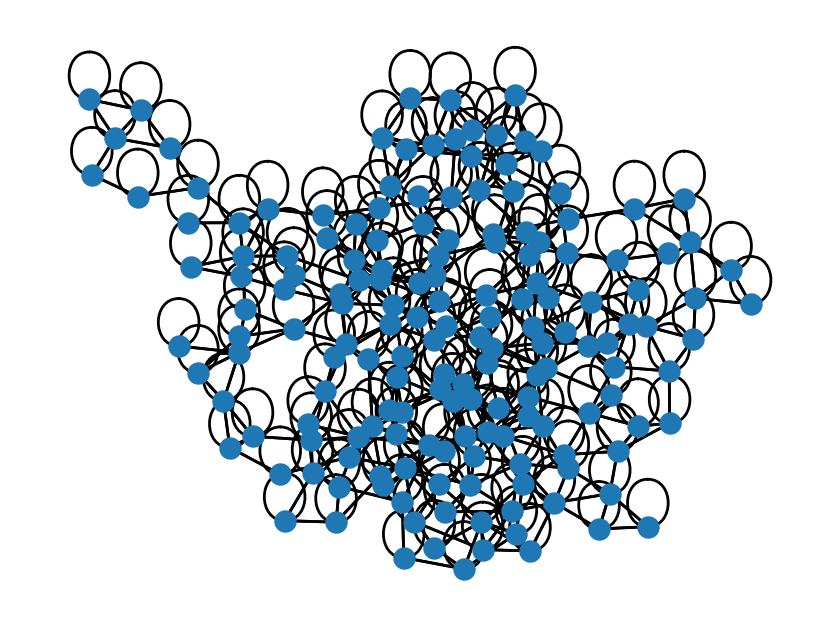

In [5]:
nx_graph = dgl.to_networkx(graph)
plt.figure(figsize=(4, 3), dpi=200)
nx.draw(nx_graph, pos=nx.kamada_kawai_layout(nx_graph), node_size=50, arrows=False)
plt.show()

In [6]:
from biopandas.mol2 import PandasMol2

pmol = PandasMol2().read_mol2(f"{proteins_dir}1clu_ligand_GppNHP_199_dock1/1clu_ligand_GppNHP_199_dock1.mol2")
pmol.df

atom_id atom_name        x        y        z atom_type  subst_id  \
0         1        O1   4.4430  31.5707  21.6969     O.co2         1   
1         2        P2   4.2232  33.0239  21.2377       P.3         1   
2         3        O3   4.4757  34.0673  22.3371     O.co2         1   
3         4        O4   2.9266  33.2395  20.4494     O.co2         1   
4         5        N5   5.6506  33.2122  19.9552       N.3         1   
5         6        P6   7.2235  32.4940  20.1544       P.3         1   
6         7        O7   7.6254  32.7699  21.5712     O.co2         1   
7         8        O8   7.2627  31.1015  19.5608     O.co2         1   
8         9        O9   8.2071  33.4519  19.1914       O.3         1   
9        10       P10   9.1306  34.8601  19.2731       P.3         1   
10       11       O11  10.0251  34.8072  18.0600     O.co2         1   
11       12       O12   8.2127  36.0154  19.5764     O.co2         1   
12       13       O13  10.0675  34.5508  20.6981       O.3         1   
13       14       C14  11.2648  33.8030  20.5800       C.3         1   
14       15       C15  12.4301  34.5442  21.2827       C.3         1   
15       16       O16  13.6632  33.9574  20.8675       O.3         1   
16       17       C17  13.5089  36.0330  19.6948       C.3         1   
17       18       O18  14.3901  37.1429  19.5617       O.3         1   
18       19       C19  12.6282  36.0296  20.9417       C.3         1   
19       20       O20  13.2353  36.7381  22.0123       O.3         1   
20       21       C21  14.3093  34.7443  19.9005       C.3         1   
21       22       N22  14.5899  33.9365  18.6504     N.pl3         1   
22       23       C23  15.8157  33.5782  18.1592       C.2         1   
23       24       N24  17.0403  33.8463  18.7060       N.2         1   
24       25       C25  18.0215  33.4265  17.9764       C.2         1   
25       26       N26  19.2901  33.5927  18.3559     N.pl3         1   
26       27       N27  17.8395  32.7705  16.7742      N.am         1   
27       28       C28  16.6536  32.4219  16.1858       C.2         1   
28       29       O29  16.5983  31.7555  15.1605       O.2         1   
29       30       C30  15.5581  32.9208  16.9877       C.2         1   
30       31       N31  14.2429  32.8119  16.7600       N.2         1   
31       32       C32  13.7015  33.4933  17.7348       C.2         1   
32       33       H35   5.2892  33.4095  19.0246         H         1   
33       34       H38  11.5131  33.5901  19.5472         H         1   
34       35       H39  11.1108  32.8259  21.0354         H         1   
35       36       H40  12.2947  34.4252  22.3600         H         1   
36       37       H41  12.8870  35.9258  18.8019         H         1   
37       38       H42  13.9391  37.8064  19.0166         H         1   
38       39       H43  11.6762  36.5165  20.7237         H         1   
39       40       H44  13.6756  37.5090  21.6305         H         1   
40       41       H45  15.2793  34.9851  20.3444         H         1   
41       42       H46  20.0665  33.2658  17.7677         H         1   
42       43       H47  19.4989  34.0495  19.2299         H         1   
43       44       H48  18.6674  32.4231  16.2948         H         1   
44       45       H49  12.6454  33.6939  17.8253         H         1   

   subst_name  charge  
0         UNK -1.0463  
1         UNK  1.6324  
2         UNK -1.0463  
3         UNK -1.0463  
4         UNK -0.8747  
5         UNK  1.1447  
6         UNK -0.8679  
7         UNK -0.8679  
8         UNK -0.5665  
9         UNK  1.3132  
10        UNK -0.8557  
11        UNK -0.8557  
12        UNK -0.4966  
13        UNK  0.1468  
14        UNK  0.1273  
15        UNK -0.3958  
16        UNK  0.0638  
17        UNK -0.6361  
18        UNK  0.1421  
19        UNK -0.6224  
20        UNK  0.1077  
21        UNK  0.0080  
22        UNK  0.1838  
23        UNK -0.3196  
24        UNK  0.3009  
25        UNK -0.7401  
26        UNK -0.1803  
27        UNK  0.32

In [7]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from Bio import PDB


In [8]:
os.getcwd()

'/Users/azamat/Desktop/UC/STDM/project/project_code'

In [9]:
os.listdir('./')

['dgl_graph.bin',
 'koff_dataset',
 '.DS_Store',
 'combined_graphs.bin',
 'koff_data_cleaned.csv',
 'Koff_QNN.ipynb',
 '.gitignore',
 '.virtual_documents',
 '.ipynb_checkpoints',
 '.git']

In [10]:
os.listdir('./koff_dataset/')

['~$koff_index.xlsx',
 '.DS_Store',
 'after_md',
 'initial_structure',
 'README.md',
 'koff_index copy.xlsx',
 'koff_index.csv',
 'README.txt',
 'koff_index.xlsx',
 'structure.txt']

In [11]:
koff_data = pd.read_csv("./koff_dataset/koff_index.csv")

In [12]:
koff_data.head()

pdbcode uniprot ID                 ligand name        koff/s-1  \
0    3hec      q16539  3hec_ligand_native_1.mol2            0.38   
1    3heg      q16539  3heg_ligand_native_2.mol2           0.018   
2     NaN      q16539  1kv2_ligand_native_3.mol2       0.0000083   
3     NaN      q16539  1kv1_ligand_native_4.mol2           0.062   
4    3gcq      q16539  3gcq_ligand_native_5.mol2  1.695e-3/0.046   

                      method  temperature protein type  \
0  Surface plasmon resonance          NaN         P38α   
1  Surface plasmon resonance          NaN         P38α   
2  Surface plasmon resonance          NaN         P38α   
3  Surface plasmon resonance          NaN         P38α   
4        Fluorescence change          NaN         P38α   

                                              smiles  \
0  O=C(Nc1cc(Nc2nc(-c3cnccc3)ccn2)c(C)cc1)c1ccc(C...   
1  Clc1c(C(F)(F)F)cc(NC(=O)Nc2ccc(Oc3cc(C(=O)NC)n...   
2  O=C(Nc1n(-c2ccc(C)cc2)nc(C(C)(C)C)c1)Nc1c2c(c(...   
3            Clc1ccc(NC(=O)Nc2n(C)nc(C(C)(C)C)c2)cc1   
4  O=C(Nc1n(-c2cc(C)ccc2)nc(C(C)(C)C)c1)Nc1ccc(Nc...   

                                  reference  cluster  
0         Biochemistry. 2010, 49, 3611-3618       51  
1         Biochemistry. 2010, 49, 3611-3618       51  
2         Biochemistry. 2010, 49, 3611-3618       51  
3         Biochemistry. 2010, 49, 3611-3618       51  
4  J. AM. CHEM. SOC. 2009, 131, 13286–13296       51

In [467]:
koff_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pdbcode       384 non-null    object 
 1   uniprot ID    669 non-null    object 
 2   ligand name   680 non-null    object 
 3   koff/s-1      680 non-null    object 
 4   method        652 non-null    object 
 5   temperature   404 non-null    float64
 6   protein type  680 non-null    object 
 7   smiles        680 non-null    object 
 8   reference     680 non-null    object 
 9   cluster       680 non-null    int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 53.3+ KB


In [17]:
!which python

/Users/azamat/anaconda3/bin/python


In [468]:
koff_data = koff_data.drop( ['temperature', 'uniprot ID ', 'reference', 'cluster'] , axis=1)

In [469]:
koff_data.head(50)

pdbcode                    ligand name        koff/s-1  \
0     3hec      3hec_ligand_native_1.mol2            0.38   
1     3heg      3heg_ligand_native_2.mol2           0.018   
2      NaN      1kv2_ligand_native_3.mol2       0.0000083   
3      NaN      1kv1_ligand_native_4.mol2           0.062   
4     3gcq      3gcq_ligand_native_5.mol2  1.695e-3/0.046   
5     3gcv      3gcv_ligand_native_6.mol2  1.159e-3/0.119   
6     3d83     3d83_ligand_native_10.mol2          0.0084   
7     3d7z     3d7z_ligand_native_11.mol2           0.023   
8     3gcp     3gcp_ligand_native_12.mol2           0.016   
9     2yiw     2yiw_ligand_native_16.mol2         0.00004   
10    2yis     2yis_ligand_native_17.mol2       0.0000024   
11    2yix     2yix_ligand_native_18.mol2           0.014   
12    2bak     2bak_ligand_native_19.mol2           0.004   
13    2baj     2baj_ligand_native_20.mol2          0.0011   
14    3uvq     3uvq_ligand_native_21.mol2          0.0129   
15     NaN    5mty_ligand_6b_23_dock.mol2         0.00208   
16     NaN    5mty_ligand_6e_24_dock.mol2           0.002   
17     NaN    5mty_ligand_6g_25_dock.mol2        0.000273   
18    5mty     5mty_ligand_native_26.mol2        0.000753   
19     NaN    5mty_ligand_6l_27_dock.mol2          0.0322   
20     NaN    5mty_ligand_6q_28_dock.mol2        0.000244   
21     NaN    5mty_ligand_8b_29_dock.mol2         0.00386   
22     NaN    5mty_ligand_8m_30_dock.mol2          0.0309   
23     NaN    5mty_ligand_6o_31_dock.mol2          0.0117   
24     NaN     4kin_ligand_3_32_dock.mol2      3.4e-3/0.6   
25     NaN    4kin_ligand_5q_33_dock.mol2      2.5e-2/0.5   
26    4mzn     4mzn_ligand_native_34.mol2   7.94e-2/0.397   
27    5jt9     5jt9_ligand_native_35.mol2   5.97e-2/0.307   
28    5js3     5js3_ligand_native_36.mol2   3.87e-2/0.509   
29    5jvi     5jvi_ligand_native_37.mol2    6.64e-2/1.49   
30    5jss     5jss_ligand_native_38.mol2   7.00e-2/0.598   
31     NaN     5lwd_ligand_1_39_dock.mol2         0.00506   
32     NaN     5lwd_ligand_2_40_dock.mol2         0.00277   
33     NaN     5lwd_ligand_3_41_dock.mol2         0.00287   
34     NaN     5lwd_ligand_4_42_dock.mol2         0.00786   
35    5lif     5lif_ligand_native_43.mol2          0.0463   
36    5lwd     5lwd_ligand_native_44.mol2          0.0446   
37     NaN     5lwd_ligand_7_45_dock.mol2           0.615   
38     NaN     5lwd_ligand_8_46_dock.mol2           0.171   
39     NaN     5lwd_ligand_9_47_dock.mol2           0.234   
40     NaN    5lwd_ligand_10_48_dock.mol2           0.208   
41     NaN    5lwd_ligand_12_50_dock.mol2           0.182   
42     NaN    5lwd_ligand_13_51_dock.mol2            0.14   
43     NaN  4ocz_ligand_apau_56_dock.mol2    1.92e-3/0.07   
44    4od0     4od0_ligand_native_57.mol2    1.05e-3/0.02   
45    4ocz     4ocz_ligand_native_58.mol2     6.57e-4/0.3   
46     NaN     4ocz_ligand_5_59_dock.mol2    7.91e-4/0.31   
47     NaN     4ocz_ligand_9_61_dock.mol2    4.75e-4/0.11   
48     NaN   4ocz_ligand_11R_62_dock.mol2    5.79e-4/0.43   
49     NaN   4ocz_ligand_13R_63_dock.mol2    3.13e-4/0.06   

                       method               protein type  \
0   Surface plasmon resonance                       P38α   
1   Surface plasmon resonance                       P38α   
2   Surface plasmon resonance                       P38α   
3   Surface plasmon resonance                       P38α   
4         Fluorescence change                       P38α   
5         Fluorescence change                       P38α   
6   Surface plasmon resonance                       P38α   
7   Surface plasmon resonance                       P38α   
8   Surface plasmon resonance                       P38α   
9   Surface plasmon resonance                       P38α   
10  Surface plasmon resonance                       P38α   
11  Surface plasmon resonance                       P38α   
12  Surface plasmon resonance                       P38α   
13  Surface plasmon resonance                      

In [470]:
koff_data['method'] = koff_data['method'].str.lower().str.strip().str.replace(r'[\s-]+', '_', regex=True)

# 39 unique 'methods'

In [471]:
koff_data['protein type'] = koff_data['protein type'].str.lower().str.strip().str.replace(r'[\s-]+', '_', regex=True)

# 143 unique 'protein types'

In [556]:
# len(koff_data['protein type'].unique())

143

In [473]:
method_mapping = {
    'surface_plasma_resonance': 'surface_plasmon_resonance',  # Standardizing similar names
    'proteros_reportor_displacement_assay': 'proteros_reporter_displacement',  # Standardizing typo
    'bio_layer_interferometry': 'biolayer_interferometry',  # Standardizing spacing variation
    'biolayer_interferometry_method': 'biolayer_interferometry',  # Standardizing method suffix
    'biolayer_interferometry_(bli)_binding_assay': 'biolayer_interferometry',  # Standardizing
    'a_stopped_flow_fluorescence': 'stopped_flow_fluorescence',  # Standardizing variation
    'fluorescence_polarization_displacement_assay': 'fluorescence_polarization',  # Specific form
    'stopped_flow_spectrometry': 'stopped_flow_spectroscopy',  # Standardizing term
    'stopped_flow_spectrofluorimetry': 'stopped_flow_spectroscopy',  # Standardizing term
    'fpa_assay': 'fluorescence_polarization',  # Mapping abbreviation to full name
    'cold_chase_radiometric_method': 'radioligand_displacement_assay',  # Similar methods
    'steady_state_inhibitor_kinetics': 'steady_state_kinetic_analysis',  # Related method
    'fluorescently_labeled': 'fluorescent_labeled_kinase_assay',  # Standardizing name
    'stopped_flow_kinetics': 'stopped_flow_spectroscopy',  # Mapping to a general method
    'reporter_displacement': 'proteros_reporter_displacement',  # Similar method
    'fluorescence': 'fluorescence_change',  # Assume fluorescence falls under change
    'biacore': 'surface_plasmon_resonance',  # Biacore is a brand of SPR equipment
}

In [474]:
koff_data['method'] = koff_data['method'].replace(method_mapping)

In [475]:
koff_data['method'].unique()

array(['surface_plasmon_resonance', 'fluorescence_change',
       'ret_based_displacement_assay', 'fluorescence_polarization',
       'stopped_flow', 'stopped_flow_competition',
       'stopped_flow_spectroscopy', 'slow_binding_inhibition', nan,
       'proteros_reporter_displacement', 'radioligand_displacement_assay',
       'bioluminescence_resonance_energy_transfer',
       'fluorescent_labeled_kinase_assay', 'biolayer_interferometry',
       'spectrophotometric_method',
       'radiometric_filter_binding_and_spin_column',
       'michaelis_menten_kinetics', 'stopped_flow_fluorescence',
       'isothermal_titration_calorimetry',
       'steady_state_kinetic_analysis', 'radiolabeled',
       'radioligand_binding_analysis'], dtype=object)

In [476]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoded_data = encoder.fit_transform(koff_data[['method']])

In [477]:
# Remove rows with NaN values in the 'method' column. There are no NaN values in the protein type column
koff_data = koff_data.dropna(subset=['method'])

In [478]:
koff_data.loc[3]['ligand name'][:4]

'1kv1'

In [491]:
koff_data['pdbcode'] = koff_data['ligand name'].str[:4]

In [492]:
koff_data

pdbcode                  ligand name        koff/s-1  \
0      3hec    3hec_ligand_native_1.mol2            0.38   
1      3heg    3heg_ligand_native_2.mol2           0.018   
2      1kv2    1kv2_ligand_native_3.mol2       0.0000083   
3      1kv1    1kv1_ligand_native_4.mol2           0.062   
4      3gcq    3gcq_ligand_native_5.mol2  1.695e-3/0.046   
..      ...                          ...             ...   
675    3oxc  3oxc_ligand_native_783.mol2         0.00023   
676    1hxw  1hxw_ligand_native_784.mol2         0.00216   
677    1ohr  1ohr_ligand_native_785.mol2         0.00067   
678    2bpx  2bpx_ligand_native_786.mol2         0.00158   
679    3ekv  3ekv_ligand_native_787.mol2         0.00488   

                        method    protein type  \
0    surface_plasmon_resonance            p38α   
1    surface_plasmon_resonance            p38α   
2    surface_plasmon_resonance            p38α   
3    surface_plasmon_resonance            p38α   
4          fluorescence_change            p38α   
..                         ...             ...   
675  surface_plasmon_resonance  hiv_1_protease   
676  surface_plasmon_resonance  hiv_1_protease   
677  surface_plasmon_resonance  hiv_1_protease   
678  surface_plasmon_resonance  hiv_1_protease   
679  surface_plasmon_resonance  hiv_1_protease   

                                                smiles  
0    O=C(Nc1cc(Nc2nc(-c3cnccc3)ccn2)c(C)cc1)c1ccc(C...  
1    Clc1c(C(F)(F)F)cc(NC(=O)Nc2ccc(Oc3cc(C(=O)NC)n...  
2    O=C(Nc1n(-c2ccc(C)cc2)nc(C(C)(C)C)c1)Nc1c2c(c(...  
3              Clc1ccc(NC(=O)Nc2n(C)nc(C(C)(C)C)c2)cc1  
4    O=C(Nc1n(-c2cc(C)ccc2)nc(C(C)(C)C)c1)Nc1ccc(Nc...  
..                                                 ...  
675  O=C(NC(C(O)C[N+H]1C(C(=O)NC(C)(C)C)CC2C(C1)CCC...  
676  O=C(OCc1scnc1)NC(C(O)CC(NC(=O)C(NC(=O)N(Cc1nc(...  
677  S(CC(NC(=O)c1c(C)c(O)ccc1)C(O)C[N+H]1C(C(=O)NC...  
678  O=C(NC1C(O)Cc2c1cccc2)C(CC(O)C[N+H]1C(C(=O)NC(...  
679  S(=O)(=O)(N(CC(O)C(NC(=O)OC1COCC1)Cc1ccccc1)CC...  

[652 rows x 6 columns]

In [494]:
koff_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652 entries, 0 to 679
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pdbcode       652 non-null    object
 1   ligand name   652 non-null    object
 2   koff/s-1      652 non-null    object
 3   method        652 non-null    object
 4   protein type  652 non-null    object
 5   smiles        652 non-null    object
dtypes: object(6)
memory usage: 51.8+ KB


In [495]:
koff_data[['koff_main', 'koff_secondary']] = koff_data['koff/s-1'].str.split('/', expand=True)

In [496]:
koff_data

pdbcode                  ligand name        koff/s-1  \
0      3hec    3hec_ligand_native_1.mol2            0.38   
1      3heg    3heg_ligand_native_2.mol2           0.018   
2      1kv2    1kv2_ligand_native_3.mol2       0.0000083   
3      1kv1    1kv1_ligand_native_4.mol2           0.062   
4      3gcq    3gcq_ligand_native_5.mol2  1.695e-3/0.046   
..      ...                          ...             ...   
675    3oxc  3oxc_ligand_native_783.mol2         0.00023   
676    1hxw  1hxw_ligand_native_784.mol2         0.00216   
677    1ohr  1ohr_ligand_native_785.mol2         0.00067   
678    2bpx  2bpx_ligand_native_786.mol2         0.00158   
679    3ekv  3ekv_ligand_native_787.mol2         0.00488   

                        method    protein type  \
0    surface_plasmon_resonance            p38α   
1    surface_plasmon_resonance            p38α   
2    surface_plasmon_resonance            p38α   
3    surface_plasmon_resonance            p38α   
4          fluorescence_change            p38α   
..                         ...             ...   
675  surface_plasmon_resonance  hiv_1_protease   
676  surface_plasmon_resonance  hiv_1_protease   
677  surface_plasmon_resonance  hiv_1_protease   
678  surface_plasmon_resonance  hiv_1_protease   
679  surface_plasmon_resonance  hiv_1_protease   

                                                smiles  koff_main  \
0    O=C(Nc1cc(Nc2nc(-c3cnccc3)ccn2)c(C)cc1)c1ccc(C...       0.38   
1    Clc1c(C(F)(F)F)cc(NC(=O)Nc2ccc(Oc3cc(C(=O)NC)n...      0.018   
2    O=C(Nc1n(-c2ccc(C)cc2)nc(C(C)(C)C)c1)Nc1c2c(c(...  0.0000083   
3              Clc1ccc(NC(=O)Nc2n(C)nc(C(C)(C)C)c2)cc1      0.062   
4    O=C(Nc1n(-c2cc(C)ccc2)nc(C(C)(C)C)c1)Nc1ccc(Nc...   1.695e-3   
..                                                 ...        ...   
675  O=C(NC(C(O)C[N+H]1C(C(=O)NC(C)(C)C)CC2C(C1)CCC...    0.00023   
676  O=C(OCc1scnc1)NC(C(O)CC(NC(=O)C(NC(=O)N(Cc1nc(...    0.00216   
677  S(CC(NC(=O)c1c(C)c(O)ccc1)C(O)C[N+H]1C(C(=O)NC...    0.00067   
678  O=C(NC1C(O)Cc2c1cccc2)C(CC(O)C[N+H]1C(C(=O)NC(...    0.00158   
679  S(=O)(=O)(N(CC(O)C(NC(=O)OC1COCC1)Cc1ccccc1)CC...    0.00488   

    koff_secondary  
0             None  
1             None  
2             None  
3             None  
4            0.046  
..             ...  
675           None  
676           None  
677           None  
678           None  
679           None  

[652 rows x 8 columns]

In [497]:
# convert to numeric, keeping NaN for missing secondary values
koff_data['koff_main'] = pd.to_numeric(koff_data['koff_main'], errors='coerce')
koff_data['koff_secondary'] = pd.to_numeric(koff_data['koff_secondary'], errors='coerce')

In [498]:
# choose inputs with only one Koff, unambiguous.

koff_data_cleaned = koff_data.loc[koff_data['koff_secondary'].isna()].drop(columns=["koff_secondary"])
# koff_data_cleaned.to_csv("koff_data_cleaned.csv", index=False)

In [499]:
koff_data_cleaned.head(60)

pdbcode                          ligand name        koff/s-1  \
0      3hec            3hec_ligand_native_1.mol2            0.38   
1      3heg            3heg_ligand_native_2.mol2           0.018   
2      1kv2            1kv2_ligand_native_3.mol2       0.0000083   
3      1kv1            1kv1_ligand_native_4.mol2           0.062   
6      3d83           3d83_ligand_native_10.mol2          0.0084   
7      3d7z           3d7z_ligand_native_11.mol2           0.023   
8      3gcp           3gcp_ligand_native_12.mol2           0.016   
9      2yiw           2yiw_ligand_native_16.mol2         0.00004   
10     2yis           2yis_ligand_native_17.mol2       0.0000024   
11     2yix           2yix_ligand_native_18.mol2           0.014   
12     2bak           2bak_ligand_native_19.mol2           0.004   
13     2baj           2baj_ligand_native_20.mol2          0.0011   
14     3uvq           3uvq_ligand_native_21.mol2          0.0129   
15     5mty          5mty_ligand_6b_23_dock.mol2         0.00208   
16     5mty          5mty_ligand_6e_24_dock.mol2           0.002   
17     5mty          5mty_ligand_6g_25_dock.mol2        0.000273   
18     5mty           5mty_ligand_native_26.mol2        0.000753   
19     5mty          5mty_ligand_6l_27_dock.mol2          0.0322   
20     5mty          5mty_ligand_6q_28_dock.mol2        0.000244   
21     5mty          5mty_ligand_8b_29_dock.mol2         0.00386   
22     5mty          5mty_ligand_8m_30_dock.mol2          0.0309   
23     5mty          5mty_ligand_6o_31_dock.mol2          0.0117   
31     5lwd           5lwd_ligand_1_39_dock.mol2         0.00506   
32     5lwd           5lwd_ligand_2_40_dock.mol2         0.00277   
33     5lwd           5lwd_ligand_3_41_dock.mol2         0.00287   
34     5lwd           5lwd_ligand_4_42_dock.mol2         0.00786   
35     5lif           5lif_ligand_native_43.mol2          0.0463   
36     5lwd           5lwd_ligand_native_44.mol2          0.0446   
37     5lwd           5lwd_ligand_7_45_dock.mol2           0.615   
38     5lwd           5lwd_ligand_8_46_dock.mol2           0.171   
39     5lwd           5lwd_ligand_9_47_dock.mol2           0.234   
40     5lwd          5lwd_ligand_10_48_dock.mol2           0.208   
41     5lwd          5lwd_ligand_12_50_dock.mol2           0.182   
42     5lwd          5lwd_ligand_13_51_dock.mol2            0.14   
64     2e27          2e27_ligand_native_112.mol2         0.00035   
73     2a9n          2a9n_ligand_native_121.mol2          0.0044   
84     4xhe          4xhe_ligand_native_139.mol2             e-3   
87     3quy          3quy_ligand_native_145.mol2  2.20e-2/0,0283   
109    3qri          3qri_ligand_native_169.mol2       0.0000295   
110    3qri  3qri_ligand_nilotinib_172_dock.mol2         0.00003   
111    3qrj          3qrj_ligand_native_173.mol2       0.0000215   
112    2gqg          2gqg_ligand_native_174.mol2       0.0000533   
113    5mes    5mes_ligand_12_177_dock1_moe.mol2           0.158   
114    5mes    5mes_ligand_13_178_dock1_moe.mol2           0.212   
115    5mes    5mes_ligand_14_179_dock1_moe.mol2           0.082   
116    5mev    5mev_ligand_20_180_dock1_moe.mol2           0.476   
117    5mes          5mes_ligand_native_181.mol2           0.073   
118    5mev    5mev_ligand_24_182_dock1_moe.mol2           0.336   
119    5mev    5mev_ligand_25_183_dock1_moe.mol2           0.213   
120    5mev    5mev_ligand_26_184_dock1_moe.mol2           0.066   
121    3utu          3utu_ligand_native_185.mol2          0.0011   
122    3utu         3utu_ligand_54_186_dock.mol2          0.0039   
123    3utu         3utu_ligand_55_187_dock.mol2          0.0024   
124    3utu         3utu_ligand_56_188_dock.mol2          0.0029   
125    3utu         3utu_ligand_57_189_dock.mol2          0.0035   
126    3utu         3utu_ligand_58_190_dock.mol2          0.0033   
127    3utu         3utu_ligand_59_191_dock.mol2            0.01   
128    3utu         3utu_ligand_61_192_dock.mol2          0.

In [500]:
koff_data_cleaned = koff_data_cleaned.drop(['koff/s-1'], axis = 1)

In [501]:
koff_data_cleaned = koff_data_cleaned.dropna(subset=['koff_main'])

In [502]:
koff_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482 entries, 0 to 679
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pdbcode       482 non-null    object 
 1   ligand name   482 non-null    object 
 2   method        482 non-null    object 
 3   protein type  482 non-null    object 
 4   smiles        482 non-null    object 
 5   koff_main     482 non-null    float64
dtypes: float64(1), object(5)
memory usage: 26.4+ KB


In [503]:
koff_data_cleaned = koff_data_cleaned.sort_values(by="ligand name")

In [504]:
koff_data_cleaned.iloc[393]['ligand name'][:4]

'5zyj'

In [505]:
# koff_data_cleaned.to_csv("koff_data_cleaned.csv", index=False)

In [645]:
koff_data_cleaned = pd.read_csv("koff_data_cleaned2.csv")

In [646]:
koff_data_cleaned

pdbcode                           ligand name                                      method                                       protein type                                             smiles     koff_main                                      method_onehot                                protein_type_onehot
0      1d4h           1d4h_ligand_native_749.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C(NCc1ccccc1)C(OCc1ccccc1)C(O)C(O)C(OCc1cccc...  6.530000e-03  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
1      1d4i           1d4i_ligand_native_771.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C(NC1C(O)Cc2c1cccc2)C(OCc1ccccc1)C(O)CC(OCc1...  2.340000e-01  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
2      1df8           1df8_ligand_native_359.mol2              radioligand_displacement_assay                                       streptavidin                      O=C([O-])CCCCC1SCC2NC(=O)NC12  5.000000e-02  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
3      1ebw        1ebw_ligand_a015_762_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...  9.380000e-01  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
4      1ebw        1ebw_ligand_a016_761_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...  6.050000e-02  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
5      1ebw        1ebw_ligand_a017_760_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...  1.790000e-01  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
6      1ebw        1ebw_ligand_a018_764_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  S(CCC(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1ccccc1...  4.740000e-01  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
7      1ebw        1ebw_ligand_b249_768_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C(OC)C(NC(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1cccc...  2.730000e-01  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
8      1ebw        1ebw_ligand_b268_757_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C(NC(C(=O)NC)C(C)C)C(OCc1ccccc1)C(O)C(O)C(OC...  3.670000e-03  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
9      1ebw        1ebw_ligand_b277_758_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C(NC(C(=O)NC)C(C)C)C(OCCC)C(O)C(O)C(OCCC)C(=...  4.850000e-03  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
10     1ebw        1ebw_ligand_b322_765_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...  6.770000e-02  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
11     1ebw        1ebw_ligand_b347_767_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...  2.700000e-02  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

In [509]:
# koff_data_cleaned['ligand name'].str[:-5].values + "_protein.pdb"

In [510]:
# One Hot encode categorical 'method' and 'protein type' columns
unique_methods         = koff_data_cleaned['method'].unique()
unique_protein_types   = koff_data_cleaned['protein type'].unique()

# Create mapping dict from method to one-hot vectors
method_to_onehot       = {method: np.eye(len(unique_methods))[idx] for idx, method in enumerate(unique_methods)}
protein_type_to_onehot = {protein_type: np.eye(len(unique_protein_types))[idx] for idx, protein_type in enumerate(unique_protein_types)}

koff_data_cleaned['method_onehot']       = koff_data_cleaned['method'].map(method_to_onehot)
koff_data_cleaned['protein_type_onehot'] = koff_data_cleaned['protein type'].map(protein_type_to_onehot)

In [517]:
# remove corrupted input
koff_data_cleaned = koff_data_cleaned[koff_data_cleaned['ligand name'] != '5zyj_ligand_e22_601_dock.mol2']
koff_data_cleaned = koff_data_cleaned[koff_data_cleaned['ligand name'] != '5zyj_ligand_native_595.mol2']


In [544]:
rows_to_remove = [365, 366, 369] + list(range(379, 389)) + list(range(397, 400)) + [413, 418, 419, 444, 445, 475, 476]

koff_data_cleaned = koff_data_cleaned.drop(index=rows_to_remove)
koff_data_cleaned = koff_data_cleaned.reset_index(drop=True)

koff_data_cleaned

pdbcode                     ligand name                          method  \
0      1d4h     1d4h_ligand_native_749.mol2       surface_plasmon_resonance   
1      1d4i     1d4i_ligand_native_771.mol2       surface_plasmon_resonance   
2      1df8     1df8_ligand_native_359.mol2  radioligand_displacement_assay   
3      1ebw  1ebw_ligand_a015_762_dock.mol2       surface_plasmon_resonance   
4      1ebw  1ebw_ligand_a016_761_dock.mol2       surface_plasmon_resonance   
..      ...                             ...                             ...   
452    6pgd    6pgd_ligand_59_710_dock.mol2       surface_plasmon_resonance   
453    6pgd     6pgd_ligand_native_709.mol2       surface_plasmon_resonance   
454    6rln     6rln_ligand_native_732.mol2       stopped_flow_spectroscopy   
455    6slg     6slg_ligand_native_646.mol2       surface_plasmon_resonance   
456    6un1     6un1_ligand_native_731.mol2       fluorescence_polarization   

                                          protein type  \
0                                       hiv_1_protease   
1                                       hiv_1_protease   
2                                         streptavidin   
3                                       hiv_1_protease   
4                                       hiv_1_protease   
..                                                 ...   
452                     wd_repeat_containing_protein_5   
453                     wd_repeat_containing_protein_5   
454  receptor_interacting_serine/threonine_protein_...   
455                 mitogen_activated_protein_kinase_1   
456                                    peptidoglycan_d   

                                                smiles  koff_main  \
0    O=C(NCc1ccccc1)C(OCc1ccccc1)C(O)C(O)C(OCc1cccc...    0.00653   
1    O=C(NC1C(O)Cc2c1cccc2)C(OCc1ccccc1)C(O)CC(OCc1...    0.23400   
2                        O=C([O-])CCCCC1SCC2NC(=O)NC12    0.05000   
3    O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...    0.93800   
4    O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...    0.06050   
..                                                 ...        ...   
452  O=C(NC(C(=O)NC(C(=O)N)C(C)C)CCCc1[nH]cc(CO)n1)...    0.02500   
453  O=C(NC(C(=O)N)C(C)C)C(NC(=O)C(NC(=O)C)C)CCCc1[...    0.06700   
454  Fc1c2NC(=O)C(NC(=O)c3nc(Cc4ccccc4)[nH]n3)CCc2c...    0.00012   
455  Fc1c(F)ccc(CN2C(=O)c3n(cc(-c4c(C)cnc(Nc5n(C)nc...    0.00006   
456  O=C([O-])C(C(=O)NC1(OC)C(=O)N2C(C(=O)[O-])C(C)...    0.00100   

                                         method_onehot  \
0    [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
1    [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
2    [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
3    [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
4    [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
..                                                 ...   
452  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
453  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
454  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
455  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   
456  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]   

                                   protein_type_onehot  
0    [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
1    [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
2    [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
3    [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
4    [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
..                                                 ...  
452  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
453  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
454  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
455  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  
456  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...  

[457 rows x 8 columns]

In [545]:
koff_data_cleaned.to_csv("koff_data_cleaned.csv", index=False)

In [546]:
koff_data_cleaned = pd.read_csv("koff_data_cleaned.csv")

In [24]:
PandasMol2().read_mol2('./koff_dataset/initial_structure/5zyj_ligand_native_595/5zyj_ligand_native_595.mol2').df

atom_id atom_name        x       y       z atom_type  subst_id subst_name  \
0         1        S1 -28.0670  6.3580 -5.6530      S.o2         1        UNK   
1         2        O2 -27.9690  6.1960 -4.2130       O.2         1        UNK   
2         3        O3 -28.0320  7.7090 -6.1950       O.2         1        UNK   
3         4        O4 -27.3870  4.6020 -8.4800       O.3         1        UNK   
4         5        N5 -34.2310  0.5890 -6.0740      N.ar         1        UNK   
..      ...       ...      ...     ...     ...       ...       ...        ...   
58       59       H59 -34.0040  3.6763 -5.4505         H         1        UNK   
59       60       H60 -37.9329  1.1157 -5.4467         H         1        UNK   
60       61       H61 -36.7825  0.7322 -6.5403         H         1        UNK   
61       62       H62 -36.2650  1.6726 -3.7896         H         1        UNK   
62       63       H63 -37.0830  3.3219 -5.2067         H         1        UNK   

    charge  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
..     ...  
58     0.0  
59     0.0  
60     0.0  
61     0.0  
62     0.0  

[63 rows x 9 columns]

In [34]:
PandasPdb().read_pdb('./koff_dataset/initial_structure/5zyj_ligand_native_595/5zyj_ligand_native_595_protein.pdb').df['ATOM']['residue_name'].unique()

array(['GLY', 'THR', 'HIE', 'ARG', 'PHE', 'VAL', 'GLN', 'LYS', 'GLU',
       'MET', 'ASN', 'TYR', 'SER', 'LEU', 'ASP', 'ALA', 'TRP', 'ILE',
       'PRO', 'HIP', 'CYS', 'HID'], dtype=object)

In [431]:
prot_df = PandasPdb().read_pdb('./koff_dataset/initial_structure/5zyj_ligand_native_595/5zyj_ligand_native_595_protein.pdb').df['ATOM']
residue_df = prot_df.groupby('residue_number', as_index=False)[['x_coord', 'y_coord', 'z_coord', 'b_factor']].mean().sort_values('residue_number')
n_residues = len(prot_df.groupby('residue_number', as_index=False))
residue_df['norm_position'] = residue_df['residue_number'] / n_residues
residue_df['residue_name'] = prot_df.groupby('residue_number', as_index=False).first()['residue_name']
residue_df

residue_number    x_coord    y_coord    z_coord  b_factor  norm_position residue_name
0                 1 -14.466333  28.538000 -14.408667       0.0       0.004237          GLY
1                 2 -17.935929  28.209214 -12.883714       0.0       0.008475          THR
2                 3 -20.644941  23.760294 -13.622235       0.0       0.012712          HIE
3                 4 -25.047292  23.939042 -17.790792       0.0       0.016949          ARG
4                 5 -26.317700  22.384500 -13.824250       0.0       0.021186          PHE
5                 6 -22.092875  26.324625 -10.010563       0.0       0.025424          VAL
6                 7 -25.648706  28.824941  -9.577235       0.0       0.029661          GLN
7                 8 -30.320136  23.554364  -8.671591       0.0       0.033898          LYS
8                 9 -24.664250  21.991688  -7.333438       0.0       0.038136          VAL
9                10 -24.446800  25.933200  -3.607133       0.0       0.042373          GLU
10               11 -29.991000  25.131067  -3.951200       0.0       0.046610          GLU
11               12 -29.786294  20.337882  -4.369000       0.0       0.050847          MET
12               13 -24.808438  20.849375  -1.395125       0.0       0.055085          VAL
13               14 -26.127941  24.655647   1.490059       0.0       0.059322          GLN
14               15 -31.436143  22.499000   0.796214       0.0       0.063559          ASN
15               16 -29.212588  17.586118   1.105235       0.0       0.067797          HIE
16               17 -24.989882  20.417059   5.110294       0.0       0.072034          MET
17               18 -30.051429  22.995429   6.395214       0.0       0.076271          THR
18               19 -33.506571  21.326190   6.053714       0.0       0.080508          TYR
19               20 -30.454091  16.067909   5.196273       0.0       0.084746          SER
20               21 -26.444316  16.274368   8.558263       0.0       0.088983          LEU
21               22 -31.616353  18.103059  11.039000       0.0       0.093220          GLN
22               23 -30.659417  13.504250  14.670917       0.0       0.097458          ASP
23               24 -34.169562  11.388625  12.484063       0.0       0.101695          VAL
24               25 -34.017143   9.726000  16.732714       0.0       0.105932          GLY
25               26 -36.133857  12.139714  18.359429       0.0       0.110169          GLY
26               27 -38.342333  12.807667  14.746000       0.0       0.114407          ASP
27               28 -42.122000  10.547200  15.935300       0.0       0.118644          ALA
28               29 -42.453857  12.896214  12.089000       0.0       0.122881          ASN
29               30 -38.121500  10.303917   9.206792       0.0       0.127119          TRP
30               31 -41.501353   4.011471  10.243353       0.0       0.131356          GLN
31               32 -36.314632   2.812947  13.190316       0.0       0.135593          LEU
32               33 -38.318438   0.369688   8.522813       0.0       0.139831          VAL
33               34 -34.484125  -2.098937   8.925875       0.0       0.144068          VAL
34               35 -31.618600  -1.342667  13.858333       0.0       0.148305          GLU
35               36 -28.252667  -4.416733  10.945733       0.0       0.152542          GLU
36               37 -26.720857  -2.121000  14.659571       0.0       0.156780          GLY
37               38 -24.349067   1.677000  14.465533       0.0       0.161017          GLU
38               39 -27.748059  -0.366882   9.311706       0.0       0.165254          MET
39               40 -29.594727   3.613909  13.409273       0.0       0.169492          LYS
40               41 -33.005125   2.038312   7.336313       0.0       0.173729          VAL
41               42 -34.890714   6.065952  10.321762       0.0       0.177966          TYR
42               43 -41.411417   4.027333   5.596458       0.0       0.182203          ARG
4

In [432]:
c = element('S')
print('Bondi: ', c.vdw_radius_bondi / 100)
print("None:  ", c.vdw_radius / 100)

Bondi:  1.8
None:   1.8


In [433]:
complex_names = koff_data_cleaned['ligand name'].str[:-5]
complex_names

0                         1d4h_ligand_native_749
1                         1d4i_ligand_native_771
2                         1df8_ligand_native_359
3                      1ebw_ligand_a015_762_dock
4                      1ebw_ligand_a016_761_dock
5                      1ebw_ligand_a017_760_dock
6                      1ebw_ligand_a018_764_dock
7                      1ebw_ligand_b249_768_dock
8                      1ebw_ligand_b268_757_dock
9                      1ebw_ligand_b277_758_dock
10                     1ebw_ligand_b322_765_dock
11                     1ebw_ligand_b347_767_dock
12                     1ebw_ligand_b365_766_dock
13                     1ebw_ligand_b376_763_dock
14                     1ebw_ligand_b408_759_dock
15                     1eby_ligand_b388_770_dock
16                        1eby_ligand_native_769
17                     1ec1_ligand_b440_751_dock
18                        1ec1_ligand_native_750
19                     1ec2_ligand_a037_754_dock
20                  

In [411]:
residues_names_full_list = []

for i in complex_names:
    pdb_path = f"./koff_dataset/initial_structure/{i}/{i}_protein.pdb"
    atom_df = PandasPdb().read_pdb(pdb_path)
    atom_df = atom_df.df['ATOM']
    res_name = atom_df.groupby('residue_number', as_index=False).first()['residue_name'].to_numpy()
    for i in res_name:
        if i not in residues_names_full_list:
            residues_names_full_list.append(i)
            
print(residues_names_full_list)

['PRO', 'GLN', 'ILE', 'THR', 'LEU', 'TRP', 'ARG', 'VAL', 'LYS', 'GLY', 'GLU', 'ALA', 'ASP', 'MET', 'SER', 'PHE', 'TYR', 'CYS', 'HID', 'ASN', 'HIS', 'HIE', 'HIP', 'ASH', 'CYX']


In [434]:
len(sorted(residues_names_full_list))

25

In [435]:
# Create mapping from 3-letter code to 1-letter code
# ---- different forms of the same resudue are encoded similarly 
# ---- e.g. (ASP, ASH) both to D, (HIS, HID, HIE, HIP) to H, (CYS, CYX) to C

amino_acid_dict = {
    'GLY': 'G',
    'ALA': 'A',
    'VAL': 'V',
    'LEU': 'L',
    'ILE': 'I',
    'THR': 'T',
    'SER': 'S',
    'MET': 'M',
    'CYS': 'C',
    'CYX': 'C',
    'PRO': 'P',
    'PHE': 'F',
    'TYR': 'Y',
    'TRP': 'W',
    'HIS': 'H',
    'HID': 'H',
    'HIE': 'H',
    'HIP': 'H',
    'LYS': 'K',
    'ARG': 'R',
    'ASP': 'D',
    'ASH': 'D',
    'GLU': 'E',
    'ASN': 'N',
    'GLN': 'Q'
}



In [436]:
residue_df['residue_name'] = residue_df['residue_name'].map(amino_acid_dict)
residue_df

residue_number    x_coord    y_coord    z_coord  b_factor  norm_position residue_name
0                 1 -14.466333  28.538000 -14.408667       0.0       0.004237            G
1                 2 -17.935929  28.209214 -12.883714       0.0       0.008475            T
2                 3 -20.644941  23.760294 -13.622235       0.0       0.012712            H
3                 4 -25.047292  23.939042 -17.790792       0.0       0.016949            R
4                 5 -26.317700  22.384500 -13.824250       0.0       0.021186            F
5                 6 -22.092875  26.324625 -10.010563       0.0       0.025424            V
6                 7 -25.648706  28.824941  -9.577235       0.0       0.029661            Q
7                 8 -30.320136  23.554364  -8.671591       0.0       0.033898            K
8                 9 -24.664250  21.991688  -7.333438       0.0       0.038136            V
9                10 -24.446800  25.933200  -3.607133       0.0       0.042373            E
10               11 -29.991000  25.131067  -3.951200       0.0       0.046610            E
11               12 -29.786294  20.337882  -4.369000       0.0       0.050847            M
12               13 -24.808438  20.849375  -1.395125       0.0       0.055085            V
13               14 -26.127941  24.655647   1.490059       0.0       0.059322            Q
14               15 -31.436143  22.499000   0.796214       0.0       0.063559            N
15               16 -29.212588  17.586118   1.105235       0.0       0.067797            H
16               17 -24.989882  20.417059   5.110294       0.0       0.072034            M
17               18 -30.051429  22.995429   6.395214       0.0       0.076271            T
18               19 -33.506571  21.326190   6.053714       0.0       0.080508            Y
19               20 -30.454091  16.067909   5.196273       0.0       0.084746            S
20               21 -26.444316  16.274368   8.558263       0.0       0.088983            L
21               22 -31.616353  18.103059  11.039000       0.0       0.093220            Q
22               23 -30.659417  13.504250  14.670917       0.0       0.097458            D
23               24 -34.169562  11.388625  12.484063       0.0       0.101695            V
24               25 -34.017143   9.726000  16.732714       0.0       0.105932            G
25               26 -36.133857  12.139714  18.359429       0.0       0.110169            G
26               27 -38.342333  12.807667  14.746000       0.0       0.114407            D
27               28 -42.122000  10.547200  15.935300       0.0       0.118644            A
28               29 -42.453857  12.896214  12.089000       0.0       0.122881            N
29               30 -38.121500  10.303917   9.206792       0.0       0.127119            W
30               31 -41.501353   4.011471  10.243353       0.0       0.131356            Q
31               32 -36.314632   2.812947  13.190316       0.0       0.135593            L
32               33 -38.318438   0.369688   8.522813       0.0       0.139831            V
33               34 -34.484125  -2.098937   8.925875       0.0       0.144068            V
34               35 -31.618600  -1.342667  13.858333       0.0       0.148305            E
35               36 -28.252667  -4.416733  10.945733       0.0       0.152542            E
36               37 -26.720857  -2.121000  14.659571       0.0       0.156780            G
37               38 -24.349067   1.677000  14.465533       0.0       0.161017            E
38               39 -27.748059  -0.366882   9.311706       0.0       0.165254            M
39               40 -29.594727   3.613909  13.409273       0.0       0.169492            K
40               41 -33.005125   2.038312   7.336313       0.0       0.173729            V
41               42 -34.890714   6.065952  10.321762       0.0       0.177966            Y
42               43 -41.411417   4.027333   5.596458       0.0       0.182203            R
4

In [437]:
df_one_hot = pd.get_dummies(residue_df['residue_name'], prefix='', prefix_sep='')
df_one_hot

A  C  D  E  F  G  H  I  K  L  M  N  P  Q  R  S  T  V  W  Y
0    0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
1    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
2    0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
3    0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
4    0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
5    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
6    0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
7    0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
8    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
9    0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
10   0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
11   0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
12   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
13   0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
14   0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
15   0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
16   0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
17   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
18   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
19   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
20   0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
21   0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
22   0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
23   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
24   0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
25   0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
26   0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
27   1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
28   0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
29   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
30   0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
31   0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
32   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
33   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
34   0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
35   0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
36   0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
37   0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
38   0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
39   0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
40   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
41   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
42   0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
43   0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
44   0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
45   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
46   0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
47   0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
48   0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
49   0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
50   0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
51   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
52   0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
53   0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
54   0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
55   0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
56   0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
57   1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
58   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
59   0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
60   1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
61   0  0  0  0  0  0  0  0  0  0  0 

In [438]:
residue_df = pd.concat([residue_df, df_one_hot], axis=1)
residue_df

residue_number    x_coord    y_coord    z_coord  b_factor  norm_position residue_name  A  C  D  E  F  G  H  I  K  L  M  N  P  Q  R  S  T  V  W  Y
0                 1 -14.466333  28.538000 -14.408667       0.0       0.004237            G  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
1                 2 -17.935929  28.209214 -12.883714       0.0       0.008475            T  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
2                 3 -20.644941  23.760294 -13.622235       0.0       0.012712            H  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
3                 4 -25.047292  23.939042 -17.790792       0.0       0.016949            R  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
4                 5 -26.317700  22.384500 -13.824250       0.0       0.021186            F  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
5                 6 -22.092875  26.324625 -10.010563       0.0       0.025424            V  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
6                 7 -25.648706  28.824941  -9.577235       0.0       0.029661            Q  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
7                 8 -30.320136  23.554364  -8.671591       0.0       0.033898            K  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
8                 9 -24.664250  21.991688  -7.333438       0.0       0.038136            V  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
9                10 -24.446800  25.933200  -3.607133       0.0       0.042373            E  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
10               11 -29.991000  25.131067  -3.951200       0.0       0.046610            E  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
11               12 -29.786294  20.337882  -4.369000       0.0       0.050847            M  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
12               13 -24.808438  20.849375  -1.395125       0.0       0.055085            V  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
13               14 -26.127941  24.655647   1.490059       0.0       0.059322            Q  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
14               15 -31.436143  22.499000   0.796214       0.0       0.063559            N  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
15               16 -29.212588  17.586118   1.105235       0.0       0.067797            H  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
16               17 -24.989882  20.417059   5.110294       0.0       0.072034            M  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
17               18 -30.051429  22.995429   6.395214       0.0       0.076271            T  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
18               19 -33.506571  21.326190   6.053714       0.0       0.080508            Y  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
19               20 -30.454091  16.067909   5.196273       0.0       0.084746            S  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
20               21 -26.444316  16.274368   8.558263       0.0       0.088983            L  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
21               22 -31.616353  18.103059  11.039000       0.0       0.093220            Q  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
22               23 -30.659417  13.504250  14.670917       0.0       0.097458            D  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
23               24 -34.169562  11.388625  12.484063       0.0       0.101695            V  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
24               25 -34.017143   9.726000  16.732714       0.0       0.105932            G  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
25               26 -36.133857  12.139714  18.359429       0.0       0.110169  

In [439]:
res_columns = sorted(residue_df['residue_name'].unique())
res_columns

['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [440]:
BLOSUM62 = pd.read_csv('blosum62.csv')
BLOSUM62 = BLOSUM62[res_columns][BLOSUM62.index.isin(res_columns)].sort_index()
BLOSUM62.to_csv('blosum62_clean.csv', index=True)

In [441]:
BLOSUM62 = pd.read_csv('blosum62_clean.csv', index_col=0)
BLOSUM62

A  C  D  E  F  G  H  I  K  L  M  N  P  Q  R  S  T  V   W  Y
A  4  0 -2 -1 -2  0 -2 -1 -1 -1 -1 -2 -1 -1 -1  1  0  0  -3 -2
C  0  9 -3 -4 -2 -3 -3 -1 -3 -1 -1 -3 -3 -3 -3 -1 -1 -1  -2 -2
D -2 -3  6  2 -3 -1 -1 -3 -1 -4 -3  1 -1  0 -2  0 -1 -3  -4 -3
E -1 -4  2  5 -3 -2  0 -3  1 -3 -2  0 -1  2  0  0 -1 -2  -3 -2
F -2 -2 -3 -3  6 -3 -1  0 -3  0  0 -3 -4 -3 -3 -2 -2 -1   1  3
G  0 -3 -1 -2 -3  6 -2 -4 -2 -4 -3  0 -2 -2 -2  0 -2 -3  -2 -3
H -2 -3 -1  0 -1 -2  8 -3 -1 -3 -2  1 -2  0  0 -1 -2 -3  -2  2
I -1 -1 -3 -3  0 -4 -3  4 -3  2  1 -3 -3 -3 -3 -2 -1  3  -3 -1
K -1 -3 -1  1 -3 -2 -1 -3  5 -2 -1  0 -1  1  2  0 -1 -2  -3 -2
L -1 -1 -4 -3  0 -4 -3  2 -2  4  2 -3 -3 -2 -2 -2 -1  1  -2 -1
M -1 -1 -3 -2  0 -3 -2  1 -1  2  5 -2 -2  0 -1 -1 -1  1  -1 -1
N -2 -3  1  0 -3  0  1 -3  0 -3 -2  6 -2  0  0  1  0 -3  -4 -2
P -1 -3 -1 -1 -4 -2 -2 -3 -1 -3 -2 -2  7 -1 -2 -1 -1 -2  -4 -3
Q -1 -3  0  2 -3 -2  0 -3  1 -2  0  0 -1  5  1  0 -1 -2  -2 -1
R -1 -3 -2  0 -3 -2  0 -3  2 -2 -1  0 -2  1  5 -1 -1 -3  -3 -2
S  1 -1  0  0 -2  0 -1 -2  0 -2 -1  1 -1  0 -1  4  1 -2  -3 -2
T  0 -1 -1 -1 -2 -2 -2 -1 -1 -1 -1  0 -1 -1 -1  1  5  0  -2 -2
V  0 -1 -3 -2 -1 -3 -3  3 -2  1  1 -3 -2 -2 -3 -2  0  4  -3 -1
W -3 -2 -4 -3  1 -2 -2 -3 -3 -2 -1 -4 -4 -2 -3 -3 -2 -3  11  2
Y -2 -2 -3 -2  3 -3  2 -1 -2 -1 -1 -2 -3 -1 -2 -2 -2 -1   2  7

In [442]:
BLOSUM62.columns

Index(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], dtype='object')

In [443]:
df = pd.DataFrame()

for aa in BLOSUM62.columns:
    # Add a new column for each amino acid in the BLOSUM62 matrix
    df[aa+'_BL'] = residue_df['residue_name'].map(BLOSUM62[aa])

# Display the updated DataFrame
df

A_BL  C_BL  D_BL  E_BL  F_BL  G_BL  H_BL  I_BL  K_BL  L_BL  M_BL  N_BL  P_BL  Q_BL  R_BL  S_BL  T_BL  V_BL  W_BL  Y_BL
0       0    -3    -1    -2    -3     6    -2    -4    -2    -4    -3     0    -2    -2    -2     0    -2    -3    -2    -3
1       0    -1    -1    -1    -2    -2    -2    -1    -1    -1    -1     0    -1    -1    -1     1     5     0    -2    -2
2      -2    -3    -1     0    -1    -2     8    -3    -1    -3    -2     1    -2     0     0    -1    -2    -3    -2     2
3      -1    -3    -2     0    -3    -2     0    -3     2    -2    -1     0    -2     1     5    -1    -1    -3    -3    -2
4      -2    -2    -3    -3     6    -3    -1     0    -3     0     0    -3    -4    -3    -3    -2    -2    -1     1     3
5       0    -1    -3    -2    -1    -3    -3     3    -2     1     1    -3    -2    -2    -3    -2     0     4    -3    -1
6      -1    -3     0     2    -3    -2     0    -3     1    -2     0     0    -1     5     1     0    -1    -2    -2    -1
7      -1    -3    -1     1    -3    -2    -1    -3     5    -2    -1     0    -1     1     2     0    -1    -2    -3    -2
8       0    -1    -3    -2    -1    -3    -3     3    -2     1     1    -3    -2    -2    -3    -2     0     4    -3    -1
9      -1    -4     2     5    -3    -2     0    -3     1    -3    -2     0    -1     2     0     0    -1    -2    -3    -2
10     -1    -4     2     5    -3    -2     0    -3     1    -3    -2     0    -1     2     0     0    -1    -2    -3    -2
11     -1    -1    -3    -2     0    -3    -2     1    -1     2     5    -2    -2     0    -1    -1    -1     1    -1    -1
12      0    -1    -3    -2    -1    -3    -3     3    -2     1     1    -3    -2    -2    -3    -2     0     4    -3    -1
13     -1    -3     0     2    -3    -2     0    -3     1    -2     0     0    -1     5     1     0    -1    -2    -2    -1
14     -2    -3     1     0    -3     0     1    -3     0    -3    -2     6    -2     0     0     1     0    -3    -4    -2
15     -2    -3    -1     0    -1    -2     8    -3    -1    -3    -2     1    -2     0     0    -1    -2    -3    -2     2
16     -1    -1    -3    -2     0    -3    -2     1    -1     2     5    -2    -2     0    -1    -1    -1     1    -1    -1
17      0    -1    -1    -1    -2    -2    -2    -1    -1    -1    -1     0    -1    -1    -1     1     5     0    -2    -2
18     -2    -2    -3    -2     3    -3     2    -1    -2    -1    -1    -2    -3    -1    -2    -2    -2    -1     2     7
19      1    -1     0     0    -2     0    -1    -2     0    -2    -1     1    -1     0    -1     4     1    -2    -3    -2
20     -1    -1    -4    -3     0    -4    -3     2    -2     4     2    -3    -3    -2    -2    -2    -1     1    -2    -1
21     -1    -3     0     2    -3    -2     0    -3     1    -2     0     0    -1     5     1     0    -1    -2    -2    -1
22     -2    -3     6     2    -3    -1    -1    -3    -1    -4    -3     1    -1     0    -2     0    -1    -3    -4    -3
23      0    -1    -3    -2    -1    -3    -3     3    -2     1     1    -3    -2    -2    -3    -2     0     4    -3    -1
24      0    -3    -1    -2    -3     6    -2    -4    -2    -4    -3     0    -2    -2    -2     0    -2    -3    -2    -3
25      0    -3    -1    -2    -3     6    -2    -4    -2    -4    -3     0    -2    -2    -2     0    -2    -3    -2    -3
26     -2    -3     6     2    -3    -1    -1    -3    -1    -4    -3     1    -1     0    -2     0    -1    -3    -4    -3
27      4     0    -2    -1    -2     0    -2    -1    -1    -1    -1    -2    -1    -1    -1     1     0     0    -3    -2
28     -2    -3     1     0    -3     0     1    -3     0    -3    -2     6    -2     0     0     1     0    -3    -4    -2
29     -3    -2    -4    -3     1    -2    -2    -3    -3    -2    -1    -4    -4    -2    -3    -3    -2    -3    11     2
30     -1    -3     0     2    -3    -2     0    -3     1    -2     0     0    -1     5     1     0    -1    -2    -2    -1
31     -1    -1    -4    -3     0    

In [444]:
df.columns

Index(['A_BL', 'C_BL', 'D_BL', 'E_BL', 'F_BL', 'G_BL', 'H_BL', 'I_BL', 'K_BL', 'L_BL', 'M_BL', 'N_BL', 'P_BL', 'Q_BL', 'R_BL', 'S_BL', 'T_BL', 'V_BL', 'W_BL', 'Y_BL'], dtype='object')

In [445]:
residue_columns = ['norm_position', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'A_BL', 'C_BL', 'D_BL', 'E_BL', 'F_BL', 'G_BL', 'H_BL', 'I_BL', 'K_BL', 'L_BL', 'M_BL', 'N_BL', 'P_BL', 'Q_BL', 'R_BL', 'S_BL', 'T_BL', 'V_BL', 'W_BL', 'Y_BL']


In [446]:
residue_df.columns

Index(['residue_number', 'x_coord', 'y_coord', 'z_coord', 'b_factor', 'norm_position', 'residue_name', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], dtype='object')

In [447]:
new_residue_df = pd.concat([residue_df, df], axis=1)
new_residue_df

residue_number    x_coord    y_coord    z_coord  b_factor  norm_position residue_name  A  C  D  E  F  G  H  I  K  L  M  N  P  Q  R  S  T  V  W  Y  A_BL  C_BL  D_BL  E_BL  F_BL  G_BL  H_BL  I_BL  K_BL  L_BL  M_BL  N_BL  P_BL  Q_BL  R_BL  S_BL  T_BL  V_BL  W_BL  Y_BL
0                 1 -14.466333  28.538000 -14.408667       0.0       0.004237            G  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0     0    -3    -1    -2    -3     6    -2    -4    -2    -4    -3     0    -2    -2    -2     0    -2    -3    -2    -3
1                 2 -17.935929  28.209214 -12.883714       0.0       0.008475            T  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0     0    -1    -1    -1    -2    -2    -2    -1    -1    -1    -1     0    -1    -1    -1     1     5     0    -2    -2
2                 3 -20.644941  23.760294 -13.622235       0.0       0.012712            H  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0    -2    -3    -1     0    -1    -2     8    -3    -1    -3    -2     1    -2     0     0    -1    -2    -3    -2     2
3                 4 -25.047292  23.939042 -17.790792       0.0       0.016949            R  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0    -1    -3    -2     0    -3    -2     0    -3     2    -2    -1     0    -2     1     5    -1    -1    -3    -3    -2
4                 5 -26.317700  22.384500 -13.824250       0.0       0.021186            F  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0    -2    -2    -3    -3     6    -3    -1     0    -3     0     0    -3    -4    -3    -3    -2    -2    -1     1     3
5                 6 -22.092875  26.324625 -10.010563       0.0       0.025424            V  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0     0    -1    -3    -2    -1    -3    -3     3    -2     1     1    -3    -2    -2    -3    -2     0     4    -3    -1
6                 7 -25.648706  28.824941  -9.577235       0.0       0.029661            Q  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0    -1    -3     0     2    -3    -2     0    -3     1    -2     0     0    -1     5     1     0    -1    -2    -2    -1
7                 8 -30.320136  23.554364  -8.671591       0.0       0.033898            K  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0    -1    -3    -1     1    -3    -2    -1    -3     5    -2    -1     0    -1     1     2     0    -1    -2    -3    -2
8                 9 -24.664250  21.991688  -7.333438       0.0       0.038136            V  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0     0    -1    -3    -2    -1    -3    -3     3    -2     1     1    -3    -2    -2    -3    -2     0     4    -3    -1
9                10 -24.446800  25.933200  -3.607133       0.0       0.042373            E  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0    -1    -4     2     5    -3    -2     0    -3     1    -3    -2     0    -1     2     0     0    -1    -2    -3    -2
10               11 -29.991000  25.131067  -3.951200       0.0       0.046610            E  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0    -1    -4     2     5    -3    -2     0    -3     1    -3    -2     0    -1     2     0     0    -1    -2    -3    -2
11               12 -29.786294  20.337882  -4.369000       0.0       0.050847            M  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0    -1    -1    -3    -2     0    -3    -2     1    -1     2     5    -2    -2     0    -1    -1    -1     1    -1    -1
12               13 -24.808438  20.849375  -1.395125       0.0       0.055085            V  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0     0    -1    -3    -2    -1    -3    -3     3    -2     1     1    -3    -2    -2    -3    -2     0     4    -3    -1
13               14 -26.127941  24.655647   1.490059       0.0       0.059322            Q  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0    -1    -3     0     2    -3    -2     0    -3     1    -2 

In [448]:
new_residue_df[residue_columns]

norm_position  A  C  D  E  F  G  H  I  K  L  M  N  P  Q  R  S  T  V  W  Y  A_BL  C_BL  D_BL  E_BL  F_BL  G_BL  H_BL  I_BL  K_BL  L_BL  M_BL  N_BL  P_BL  Q_BL  R_BL  S_BL  T_BL  V_BL  W_BL  Y_BL
0         0.004237  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0     0    -3    -1    -2    -3     6    -2    -4    -2    -4    -3     0    -2    -2    -2     0    -2    -3    -2    -3
1         0.008475  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0     0    -1    -1    -1    -2    -2    -2    -1    -1    -1    -1     0    -1    -1    -1     1     5     0    -2    -2
2         0.012712  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0    -2    -3    -1     0    -1    -2     8    -3    -1    -3    -2     1    -2     0     0    -1    -2    -3    -2     2
3         0.016949  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0    -1    -3    -2     0    -3    -2     0    -3     2    -2    -1     0    -2     1     5    -1    -1    -3    -3    -2
4         0.021186  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0    -2    -2    -3    -3     6    -3    -1     0    -3     0     0    -3    -4    -3    -3    -2    -2    -1     1     3
5         0.025424  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0     0    -1    -3    -2    -1    -3    -3     3    -2     1     1    -3    -2    -2    -3    -2     0     4    -3    -1
6         0.029661  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0    -1    -3     0     2    -3    -2     0    -3     1    -2     0     0    -1     5     1     0    -1    -2    -2    -1
7         0.033898  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0    -1    -3    -1     1    -3    -2    -1    -3     5    -2    -1     0    -1     1     2     0    -1    -2    -3    -2
8         0.038136  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0     0    -1    -3    -2    -1    -3    -3     3    -2     1     1    -3    -2    -2    -3    -2     0     4    -3    -1
9         0.042373  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0    -1    -4     2     5    -3    -2     0    -3     1    -3    -2     0    -1     2     0     0    -1    -2    -3    -2
10        0.046610  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0    -1    -4     2     5    -3    -2     0    -3     1    -3    -2     0    -1     2     0     0    -1    -2    -3    -2
11        0.050847  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0    -1    -1    -3    -2     0    -3    -2     1    -1     2     5    -2    -2     0    -1    -1    -1     1    -1    -1
12        0.055085  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0     0    -1    -3    -2    -1    -3    -3     3    -2     1     1    -3    -2    -2    -3    -2     0     4    -3    -1
13        0.059322  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0    -1    -3     0     2    -3    -2     0    -3     1    -2     0     0    -1     5     1     0    -1    -2    -2    -1
14        0.063559  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0    -2    -3     1     0    -3     0     1    -3     0    -3    -2     6    -2     0     0     1     0    -3    -4    -2
15        0.067797  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0    -2    -3    -1     0    -1    -2     8    -3    -1    -3    -2     1    -2     0     0    -1    -2    -3    -2     2
16        0.072034  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0    -1    -1    -3    -2     0    -3    -2     1    -1     2     5    -2    -2     0    -1    -1    -1     1    -1    -1
17        0.076271  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0     0    -1    -1    -1    -2    -2    -2    -1    -1    -1    -1     0    -1    -1    -1     1     5     0    -2    -2
18        0.080508  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1    -2    -2    -3    -2     3    -3     2    -1    -2    -1    -1    -2    -3    -1    -2    -2    -2    -1     2     7
19        0.084746  0  0 

In [218]:
from rdkit import Chem

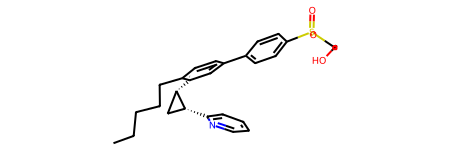

In [389]:
mol2_path = f"./koff_dataset/initial_structure/5zyj_ligand_native_595/5zyj_ligand_native_595.mol2"
mol_df = PandasMol2().read_mol2(mol2_path)
mol = Chem.MolFromMol2File(mol2_path)
mol

In [335]:
mol.GetAtoms()

In [333]:
mol_df.df

atom_id atom_name        x       y       z atom_type  subst_id subst_name  \
0         1        S1 -28.0670  6.3580 -5.6530      S.o2         1        UNK   
1         2        O2 -27.9690  6.1960 -4.2130       O.2         1        UNK   
2         3        O3 -28.0320  7.7090 -6.1950       O.2         1        UNK   
3         4        O4 -27.3870  4.6020 -8.4800       O.3         1        UNK   
4         5        N5 -34.2310  0.5890 -6.0740      N.ar         1        UNK   
..      ...       ...      ...     ...     ...       ...       ...        ...   
58       59       H59 -34.0040  3.6763 -5.4505         H         1        UNK   
59       60       H60 -37.9329  1.1157 -5.4467         H         1        UNK   
60       61       H61 -36.7825  0.7322 -6.5403         H         1        UNK   
61       62       H62 -36.2650  1.6726 -3.7896         H         1        UNK   
62       63       H63 -37.0830  3.3219 -5.2067         H         1        UNK   

    charge  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
..     ...  
58     0.0  
59     0.0  
60     0.0  
61     0.0  
62     0.0  

[63 rows x 9 columns]

In [290]:
atomic_numbers = []
degrees = []
expl_v_arr = []
impl_v_arr = []

j=0
for i in complex_names:
    # if i == "6b1y_ligand_native_643":
    #     continue
    print(f"#{j}")
    j+=1
    mol2_path = f"./koff_dataset/initial_structure/{i}/{i}.mol2"
    mol = Chem.MolFromMol2File(mol2_path)
    for atom in mol.GetAtoms():
        atom_no = atom.GetAtomicNum()
        if atom_no == 35:
            print(i)
        if atom_no not in atomic_numbers:
            atomic_numbers.append(atom_no)
        degree = atom.GetDegree()
        if degree not in degrees:
            degrees.append(degree)
        expl_v = atom.GetExplicitValence()
        if expl_v not in expl_v_arr:
            expl_v_arr.append(expl_v)
        impl_v = atom.GetImplicitValence()
        if impl_v not in impl_v_arr:
            impl_v_arr.append(impl_v)


print(atom_no)

#0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
1ebw_ligand_b408_759_dock
1ebw_ligand_b408_759_dock
#15
#16
#17
#18
#19
#20
#21
#22
#23
#24
#25
#26
#27
#28
#29
#30
#31
#32
#33
#34
#35
#36
#37
#38
#39
#40
#41
#42
#43
#44
#45
#46
#47
#48
#49
#50
#51
#52
#53
#54
1uwf_ligand_7_619_dock
#55
#56
#57
#58
#59
#60
#61
#62
#63
#64
#65
#66
#67
#68
#69
#70
#71
#72
#73
#74
#75
#76
#77
#78
#79
#80
#81
#82
#83
#84
#85
#86
#87
#88
#89
#90
#91
#92
#93
#94
#95
#96
#97
#98
#99
#100
#101
#102
#103
#104
#105
#106
#107
#108
#109
#110
#111
#112
#113
#114
#115
#116
#117
#118
#119
#120
#121
#122
#123
#124
#125
4bae_ligand_native_420
#126
#127
#128
4btm_ligand_native_337
#129
#130
#131
#132
#133
#134
#135
#136
#137
#138
#139
#140
#141
#142
#143
#144
#145
#146
#147
#148
#149
#150
#151
#152
#153
#154
#155
#156
4gu6_ligand_47_90_dock1
#157
#158
4gu6_ligand_49_92_dock
#159
4gu6_ligand_50_93_dock
#160
#161
#162
#163
#164
#165
#166
#167
#168
#169
#170
#171
#172
#173
#174
#175
#176
#177
#178
#179
#180
#181
#182
#183

[20:31:30] WARNING: not removing hydrogen atom without neighbors
[20:31:30] WARNING: not removing hydrogen atom without neighbors
[20:31:30] WARNING: not removing hydrogen atom without neighbors


#187
#188
#189
#190
#191
#192
#193
#194
#195
#196
#197
#198
#199
#200
#201
#202
#203
#204
#205
#206
#207
#208
#209
#210
#211
#212
#213
#214
#215
#216
#217
#218
#219
#220
#221
#222
#223
#224
#225
#226
#227
#228
#229
#230
#231
#232
#233
#234
#235
#236
#237
#238
#239
#240
5j2x_ligand_native_501
#241
#242
#243
#244
#245
#246
#247
#248
#249
#250
#251
#252
#253
#254
#255
#256
#257
#258
#259
#260
#261
#262
#263
#264
5j8m_ligand_native_575
#265
#266
#267
#268
#269
#270
#271
#272
#273
#274
#275
#276
#277
#278
#279
#280
#281
#282
#283
#284
#285
#286
#287
#288
#289
#290
#291
#292
5lrz_ligand_native_513
#293
#294
#295
#296
#297
#298
#299
#300
#301
#302
#303
#304
#305
#306
#307
#308
#309
#310
#311
#312
#313
#314
#315
#316
#317
#318
#319
#320
#321
#322
#323
#324
#325
#326
#327
#328
#329
#330
#331
#332
#333
#334
#335
#336
#337
#338
#339
#340
#341
#342
#343
#344
#345
#346
#347
#348
#349
#350
#351
#352
#353
5tca_ligand_1_273_dock1
#354
5tca_ligand_native_275
#355
5tcc_ligand_2_274_dock1
#356
5tcc_ligan

In [377]:
len(mol.GetAtoms())

63

In [378]:
len(mol.GetBonds())

66

In [387]:
bond_types = []
no_conj = 0
no_ring = 0
n = 0
no_conj_ring = 0
no_single = 0
no_double = 0
no_triple = 0
no_arom = 0

for i in complex_names:
    mol2_path = f"./koff_dataset/initial_structure/{i}/{i}.mol2"
    mol = Chem.AddHs(Chem.MolFromMol2File(mol2_path))
    for bond in mol.GetBonds():
        b_t = bond.GetBondType()
        n += 1
        if b_t not in bond_types:
            bond_types.append(b_t)
        if b_t == Chem.BondType.SINGLE:
            no_single +=1
        if b_t == Chem.BondType.DOUBLE:
            no_double +=1 
        if b_t == Chem.BondType.TRIPLE:
            no_triple += 1
        if b_t == Chem.BondType.AROMATIC:
            no_arom +=1
        if bond.GetIsConjugated():
            no_conj +=1
            if bond.IsInRing():
                no_conj_ring += 1
        if bond.IsInRing():
            no_ring += 1

print(bond_types)
print(f'bonds:{n}')
print(f'conj: {no_conj}')
print(f'ring: {no_ring}')
print(f'conj + ring: {no_conj_ring}')
print(f'singles: {no_single}')
print(f'doubles: {no_double}')
print(f'triples: {no_triple}')
print(f'aromatic: {no_arom}')

[09:18:25] WARNING: not removing hydrogen atom without neighbors
[09:18:25] WARNING: not removing hydrogen atom without neighbors
[09:18:25] WARNING: not removing hydrogen atom without neighbors


[rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.AROMATIC, rdkit.Chem.rdchem.BondType.TRIPLE]
bonds:29169
conj: 10394
ring: 10055
conj + ring: 7890
singles: 20506
doubles: 1080
triples: 33
aromatic: 7550


In [381]:
i = 0
for bond in mol.GetBonds():
    print(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
    print(f"{i}: {bond.GetBondType()}")
    i+=1

0 1
0: DOUBLE
0 2
1: DOUBLE
0 6
2: SINGLE
0 24
3: SINGLE
3 7
4: SINGLE
4 8
5: AROMATIC
4 25
6: AROMATIC
5 9
7: SINGLE
6 7
8: SINGLE
8 10
9: AROMATIC
9 11
10: SINGLE
10 12
11: AROMATIC
11 13
12: SINGLE
12 14
13: AROMATIC
13 17
14: SINGLE
14 25
15: AROMATIC
15 18
16: AROMATIC
15 24
17: AROMATIC
16 19
18: AROMATIC
16 24
19: AROMATIC
17 27
20: SINGLE
18 26
21: AROMATIC
19 26
22: AROMATIC
20 21
23: AROMATIC
20 27
24: AROMATIC
21 28
25: AROMATIC
22 28
26: AROMATIC
22 30
27: AROMATIC
23 29
28: SINGLE
23 31
29: SINGLE
25 29
30: SINGLE
26 28
31: SINGLE
27 30
32: AROMATIC
29 31
33: SINGLE
30 31
34: SINGLE
3 32
35: SINGLE
5 33
36: SINGLE
5 34
37: SINGLE
5 35
38: SINGLE
6 36
39: SINGLE
6 37
40: SINGLE
7 38
41: SINGLE
7 39
42: SINGLE
8 40
43: SINGLE
9 41
44: SINGLE
9 42
45: SINGLE
10 43
46: SINGLE
11 44
47: SINGLE
11 45
48: SINGLE
12 46
49: SINGLE
13 47
50: SINGLE
13 48
51: SINGLE
14 49
52: SINGLE
15 50
53: SINGLE
16 51
54: SINGLE
17 52
55: SINGLE
17 53
56: SINGLE
18 54
57: SINGLE
19 55
58: SINGLE


In [327]:
# mol = Chem.MolFromMol2File('./koff_dataset/initial_structure/6b1y_ligand_native_643/6b1y_ligand_native_643.mol2')
# mol

In [306]:
atomic_numbers = [8, 7, 6, 16, 35, 15, 17, 9, 53, 1]

atomic_number_to_symbol = {
    8: 'O', 7: 'N', 6: 'C', 16: 'S', 35: 'Br', 
    15: 'P', 17: 'Cl', 9: 'F', 53: 'I', 1: 'H'
}

atomic_numbers

[8, 7, 6, 16, 35, 15, 17, 9, 53, 1]

In [274]:
degrees = [1, 2, 3, 4, 0]
degrees

[1, 2, 3, 4, 0]

In [275]:
expl_v_arr = [2, 3, 4, 1, 5, 6, 0]
expl_v_arr

[2, 3, 4, 1, 5, 6, 0]

In [276]:
impl_v_arr = [0, 1]
impl_v_arr

[0, 1]

In [307]:
symbols_to_include = [atomic_number_to_symbol[num] for num in atomic_numbers]

In [347]:
atomic_numbers = [8, 7, 6, 16, 35, 15, 17, 9, 53, 1]
degrees = [1, 2, 3, 4, 0]
expl_v_arr = [2, 3, 4, 1, 5, 6, 0]
impl_v_arr = [0, 1]
is_aromatic = [0, 1]

# Generate column names for one-hot encoding based on each feature
lig_feat_columns = (
    [f'atom_num_{num}' for num in atomic_numbers] +
    [f'degree_{deg}' for deg in degrees] +
    [f'expl_val_{val}' for val in expl_v_arr] +
    [f'impl_val_{val}' for val in impl_v_arr] +
    [f'aromatic_{arom}' for arom in is_aromatic]
)

In [338]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [399]:
lig_feat_df = pd.DataFrame(columns=lig_feat_columns)
lig_feat_df = lig_feat_df.astype(int)  # Ensure all values are integers
lig_feat_df

rows = []

mol = Chem.AddHs(mol)

print(len(mol.GetAtoms()))

for atom in mol.GetAtoms():
    # Create a new row initialized to zeros for all columns
    new_row = {col: 0 for col in lig_feat_df.columns}
    
    # Get features of the atom
    atomic_num = atom.GetAtomicNum()
    degree = atom.GetDegree()
    expl_val = atom.GetExplicitValence()
    impl_val = atom.GetImplicitValence()
    is_aromatic = int(atom.GetIsAromatic())
    
    # Set the appropriate one-hot encoded columns to 1 based on atom's features
    # For atomic number
    atomic_col = f'atom_num_{atomic_num}'
    if atomic_col in new_row:
        new_row[atomic_col] = 1
    
    # For degree
    degree_col = f'degree_{degree}'
    if degree_col in new_row:
        new_row[degree_col] = 1

    # For explicit valence
    expl_val_col = f'expl_val_{expl_val}'
    if expl_val_col in new_row:
        new_row[expl_val_col] = 1

    # For implicit valence
    impl_val_col = f'impl_val_{impl_val}'
    if impl_val_col in new_row:
        new_row[impl_val_col] = 1

    # For aromaticity
    aromatic_col = f'aromatic_{is_aromatic}'
    if aromatic_col in new_row:
        new_row[aromatic_col] = 1

    # Append the new row to the list
    rows.append(new_row)

# Concatenate all rows to the DataFrame at once
lig_feat_df = pd.concat([lig_feat_df, pd.DataFrame(rows)], ignore_index=True)

# Display the filled DataFrame
lig_feat_df

63


atom_num_8  atom_num_7  atom_num_6  atom_num_16  atom_num_35  atom_num_15  atom_num_17  atom_num_9  atom_num_53  atom_num_1  degree_1  degree_2  degree_3  degree_4  degree_0  expl_val_2  expl_val_3  expl_val_4  expl_val_1  expl_val_5  expl_val_6  expl_val_0  impl_val_0  impl_val_1  aromatic_0  aromatic_1
0            0           0           0            1            0            0            0           0            0           0         0         0         0         1         0           0           0           0           0           0           1           0           1           0           1           0
1            1           0           0            0            0            0            0           0            0           0         1         0         0         0         0           1           0           0           0           0           0           0           1           0           1           0
2            1           0           0            0            0            0            0           0            0           0         1         0         0         0         0           1           0           0           0           0           0           0           1           0           1           0
3            1           0           0            0            0            0            0           0            0           0         0         1         0         0         0           1           0           0           0           0           0           0           1           0           1           0
4            0           1           0            0            0            0            0           0            0           0         0         1         0         0         0           0           1           0           0           0           0           0           1           0           0           1
5            0           0           1            0            0            0            0           0            0           0         0         0         0         1         0           0           0           1           0           0           0           0           1           0           1           0
6            0           0           1            0            0            0            0           0            0           0         0         0         0         1         0           0           0           1           0           0           0           0           1           0           1           0
7            0           0           1            0            0            0            0           0            0           0         0         0         0         1         0           0           0           1           0           0           0           0           1           0           1           0
8            0           0           1            0            0            0            0           0            0           0         0         0         1         0         0           0           0           1           0           0           0           0           1           0           0           1
9            0           0           1            0            0            0            0           0            0           0         0         0         0         1         0           0           0           1           0           0           0           0           1           0           1           0
10           0           0           1            0            0            0            0           0            0           0         0         0         1         0         0           0           0           1           0           0           0           0           1           0           0           1
11           0           0           1            0            0            0            0           0            0           0         0         0         0         1         0           0           0           1           0           0           0           0           1           

In [337]:


for atom in mol.GetAtoms():
    print(f"atom.n: {atom.GetAtomicNum()}")
    print(f"degree: {atom.GetDegree()}")
    print(f"expl.v: {atom.GetExplicitValence()}")
    print(f"impl.v: {atom.GetImplicitValence()}")
    print(f"is_aro: {int(atom.GetIsAromatic())}")
    print('*'*5)
    # atom_features.append(ligand_node_features(atom))

atom.n: 16
degree: 4
expl.v: 6
impl.v: 0
is_aro: 0
*****
atom.n: 8
degree: 1
expl.v: 2
impl.v: 0
is_aro: 0
*****
atom.n: 8
degree: 1
expl.v: 2
impl.v: 0
is_aro: 0
*****
atom.n: 8
degree: 2
expl.v: 2
impl.v: 0
is_aro: 0
*****
atom.n: 7
degree: 2
expl.v: 3
impl.v: 0
is_aro: 1
*****
atom.n: 6
degree: 4
expl.v: 4
impl.v: 0
is_aro: 0
*****
atom.n: 6
degree: 4
expl.v: 4
impl.v: 0
is_aro: 0
*****
atom.n: 6
degree: 4
expl.v: 4
impl.v: 0
is_aro: 0
*****
atom.n: 6
degree: 3
expl.v: 4
impl.v: 0
is_aro: 1
*****
atom.n: 6
degree: 4
expl.v: 4
impl.v: 0
is_aro: 0
*****
atom.n: 6
degree: 3
expl.v: 4
impl.v: 0
is_aro: 1
*****
atom.n: 6
degree: 4
expl.v: 4
impl.v: 0
is_aro: 0
*****
atom.n: 6
degree: 3
expl.v: 4
impl.v: 0
is_aro: 1
*****
atom.n: 6
degree: 4
expl.v: 4
impl.v: 0
is_aro: 0
*****
atom.n: 6
degree: 3
expl.v: 4
impl.v: 0
is_aro: 1
*****
atom.n: 6
degree: 3
expl.v: 4
impl.v: 0
is_aro: 1
*****
atom.n: 6
degree: 3
expl.v: 4
impl.v: 0
is_aro: 1
*****
atom.n: 6
degree: 4
expl.v: 4
impl.v: 0
is_aro:

In [349]:
mol_df.df['symbol'] = mol_df.df['atom_type'].apply(lambda x: x.split(".")[0])
# mol_df.df

# Concatenate the one-hot encoded columns back to the original DataFrame
pd.concat([mol_df.df, lig_feat_df], axis=1)

atom_id atom_name        x       y        z atom_type  subst_id subst_name  charge symbol  atom_num_8  atom_num_7  atom_num_6  atom_num_16  atom_num_35  atom_num_15  atom_num_17  atom_num_9  atom_num_53  atom_num_1  degree_1  degree_2  degree_3  degree_4  degree_0  expl_val_2  expl_val_3  expl_val_4  expl_val_1  expl_val_5  expl_val_6  expl_val_0  impl_val_0  impl_val_1  aromatic_0  aromatic_1
0         1        S1 -28.0670  6.3580  -5.6530      S.o2         1        UNK     0.0      S           0           0           0            1            0            0            0           0            0           0         0         0         0         1         0           0           0           0           0           0           1           0           1           0           1           0
1         2        O2 -27.9690  6.1960  -4.2130       O.2         1        UNK     0.0      O           1           0           0            0            0            0            0           0            0           0         1         0         0         0         0           1           0           0           0           0           0           0           1           0           1           0
2         3        O3 -28.0320  7.7090  -6.1950       O.2         1        UNK     0.0      O           1           0           0            0            0            0            0           0            0           0         1         0         0         0         0           1           0           0           0           0           0           0           1           0           1           0
3         4        O4 -27.3870  4.6020  -8.4800       O.3         1        UNK     0.0      O           1           0           0            0            0            0            0           0            0           0         0         1         0         0         0           1           0           0           0           0           0           0           1           0           1           0
4         5        N5 -34.2310  0.5890  -6.0740      N.ar         1        UNK     0.0      N           0           1           0            0            0            0            0           0            0           0         0         1         0         0         0           0           1           0           0           0           0           0           1           0           0           1
5         6        C6 -40.3680 -0.5380  -9.8500       C.3         1        UNK     0.0      C           0           0           1            0            0            0            0           0            0           0         0         0         0         1         0           0           0           1           0           0           0           0           1           0           1           0
6         7        C7 -26.6310  5.3920  -6.2750       C.3         1        UNK     0.0      C           0           0           1            0            0            0            0           0            0           0         0         0         0         1         0           0           0           1           0           0           0           0           1           0           1           0
7         8        C8 -26.5270  5.5290  -7.8130       C.3         1        UNK     0.0      C           0           0           1            0            0            0            0           0            0           0         0         0         0         1         0           0           0           1           0           0           0           0           1           0           1           0
8         9        C9 -32.9410  0.1610  -6.2540      C.ar         1        UNK     0.0      C           0           0           1            0            0            0            0           0            0           0         0         0         1         0         0           0           0           1           0           0           0           0           1           0           0       

In [359]:
def get_distance_matrix(coords):
    diff_tensor = np.expand_dims(coords, axis=1) - np.expand_dims(coords, axis=0)
    distance_matrix = np.sqrt(np.sum(np.power(diff_tensor, 2), axis=-1))
    return distance_matrix



In [367]:
dummy_lig_pos = [
    [-28.0670, 6.3580, -5.6530],
    [-27.9690, 6.1960, -4.2130],
    [-28.0320, 7.7090, -6.1950]
]

dummy_prot_pos = [
    [-14.466333, 	28.538000, 	-14.408667 	],
    [+14.466333, 	8.538000, 	-4.408667 	],
    [-10, 	22.538000, 	-1.408667 	],
]

get_distance_matrix(dummy_lig_pos)

array([[0.        , 1.45239389, 1.45608722],
       [1.45239389, 0.        , 2.49428587],
       [1.45608722, 2.49428587, 0.        ]])

In [368]:
from scipy.spatial import distance_matrix

distance_matrix(dummy_lig_pos, dummy_lig_pos)

array([[0.        , 1.45239389, 1.45608722],
       [1.45239389, 0.        , 2.49428587],
       [1.45608722, 2.49428587, 0.        ]])

In [369]:
distance_matrix(dummy_lig_pos, dummy_prot_pos)

array([[27.4516347 , 42.60733717, 24.62160132],
       [28.02567761, 42.5003616 , 24.45015764],
       [26.17897797, 42.54393652, 23.83193758]])

In [370]:
distance_matrix(dummy_prot_pos, dummy_lig_pos)

array([[27.4516347 , 28.02567761, 26.17897797],
       [42.60733717, 42.5003616 , 42.54393652],
       [24.62160132, 24.45015764, 23.83193758]])

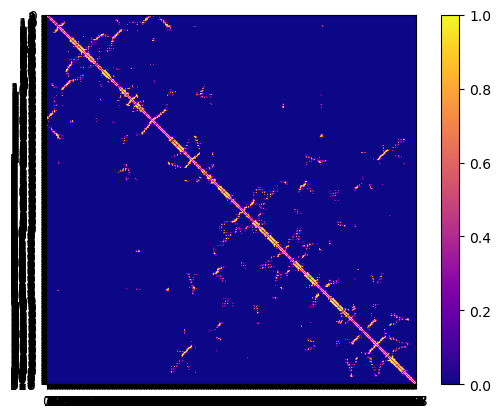

In [909]:
import dgl
import networkx as nx
import matplotlib.pyplot as plt

pdb_src_filtered = []
pdb_dest_filtered = []

for src, dest in zip(pdb_src, pdb_dest):
    if src != dest:  # Only keep edges where source is not equal to destination
        pdb_src_filtered.append(src)
        pdb_dest_filtered.append(dest)

# Create a sample DGL graph
dgl_graph = dgl.graph((pdb_src_filtered, pdb_dest_filtered))

# Convert DGL graph to NetworkX graph
nx_graph = dgl.to_networkx(dgl_graph)

# Generate contact matrix
nodes = list(nx_graph.nodes())
contact_matrix = [[1 if nx_graph.has_edge(nodes[i], nodes[j]) else 0 for j in range(len(nodes))] for i in range(len(nodes))]

# Visualize using a heatmap
plt.imshow(contact_matrix, cmap='plasma')
plt.colorbar()
plt.xticks(range(len(nodes)), nodes)
plt.yticks(range(len(nodes)), nodes)
plt.show()

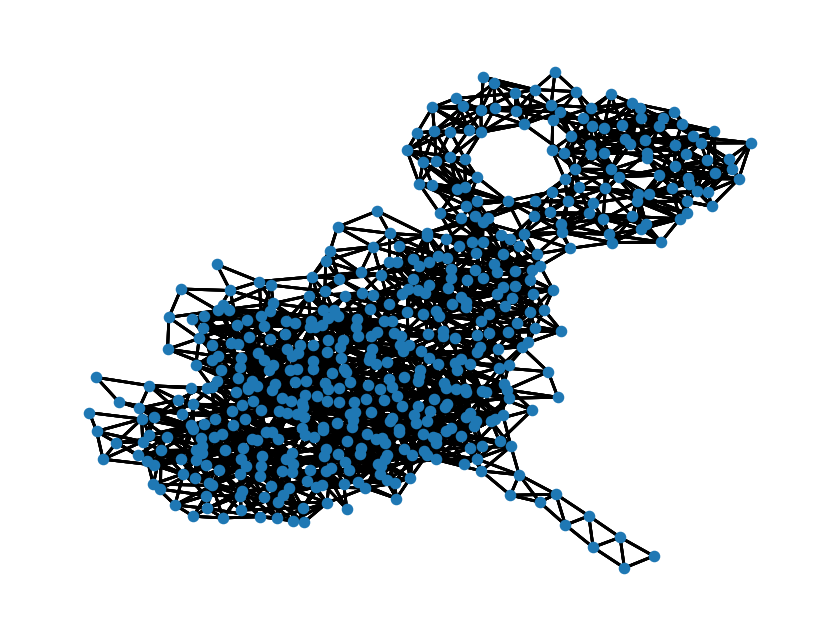

In [910]:
visualize_graph(dgl_graph)

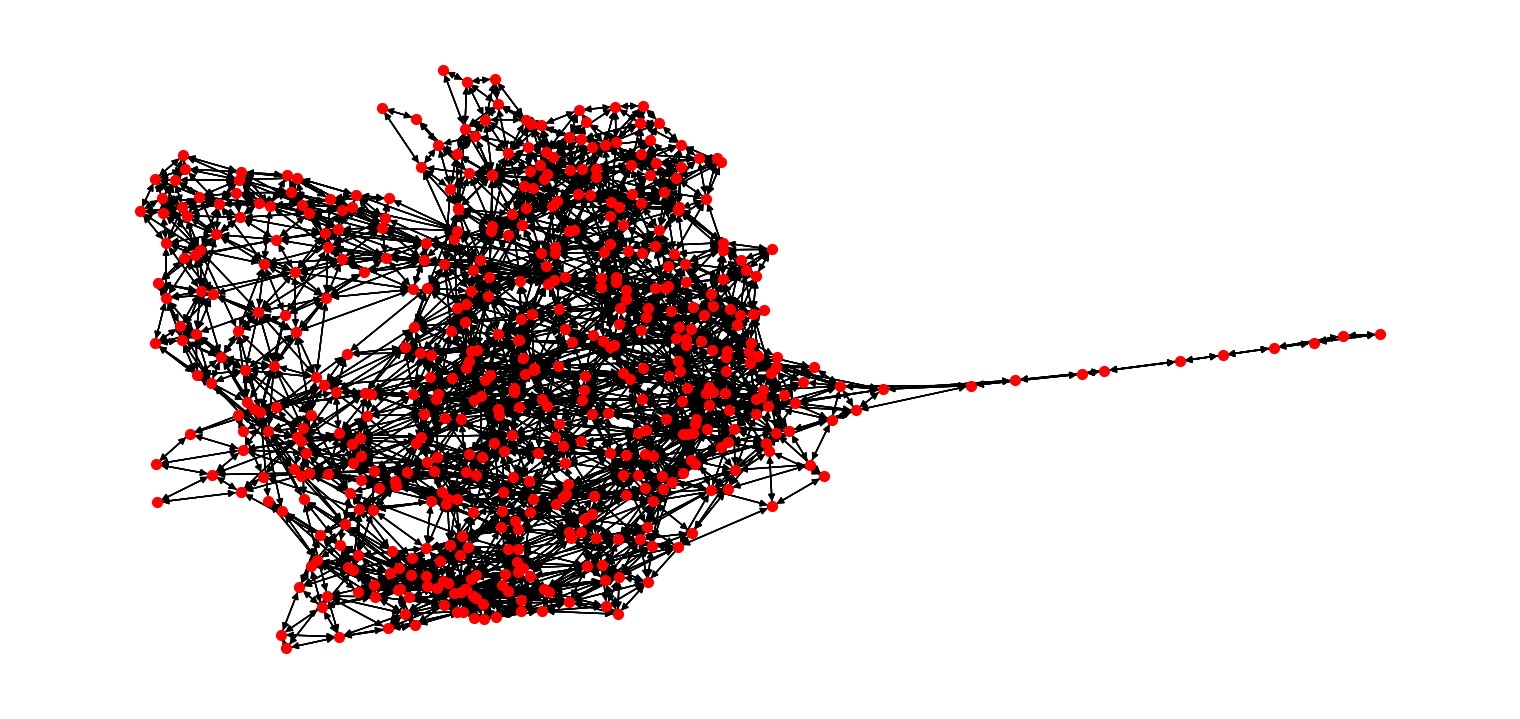

In [912]:
options = {
    'node_color': 'red',
    'node_size': 50,
    'width': 1,
}
G = dgl.to_networkx(dgl_graph)
plt.figure(figsize=[15,7])
nx.draw(G, **options)

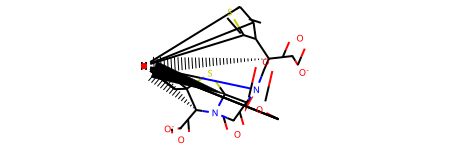

In [903]:
mol

In [395]:
nodes = []
edges = []
bond_features = []

mol = Chem.AddHs(mol)
# Add each atom as a node (using atom index or atom symbol)
for atom in mol.GetAtoms():
    nodes.append(atom.GetIdx())  # GetIdx() returns the atom index

# Add each bond as an edge (based on chemical bonds)
for bond in mol.GetBonds():
    # Get the indices of the atoms connected by the bond
    src = bond.GetBeginAtomIdx()
    dest = bond.GetEndAtomIdx()

    bond_feature = {
        'single': 0,
        'double': 0,
        'triple': 0,
        'aromatic': 0,
        'conjugated': 0,
        'ring': 0
    }

    b_t = bond.GetBondType()
    if b_t == Chem.BondType.SINGLE:
        bond_feature['single'] = 1
    elif b_t == Chem.BondType.DOUBLE:
        bond_feature['double'] = 1
    elif b_t == Chem.BondType.TRIPLE:
        bond_feature['triple'] = 1
    elif b_t == Chem.BondType.AROMATIC:
        bond_feature['aromatic'] = 1
    if bond.GetIsConjugated():
        bond_feature['conjugated'] = 1
    if bond.IsInRing():
        bond_feature['ring'] = 1
    
    # Add the edge (atom1, atom2) to the list of edges
    edges.append((src, dest))
    edges.append((dest, src))
    bond_features.append(bond_feature)
    bond_features.append(bond_feature)

# print("Nodes:", nodes)
edges_df = pd.DataFrame(edges, columns=['src', 'dest'])
bond_features_df = pd.DataFrame(bond_features)
edges_df = pd.concat([edges_df, bond_features_df], axis=1)
edges_df

src  dest  single  double  triple  aromatic  conjugated  ring
0      0     1       0       1       0         0           0     0
1      1     0       0       1       0         0           0     0
2      0     2       0       1       0         0           0     0
3      2     0       0       1       0         0           0     0
4      0     6       1       0       0         0           0     0
5      6     0       1       0       0         0           0     0
6      0    24       1       0       0         0           0     0
7     24     0       1       0       0         0           0     0
8      3     7       1       0       0         0           0     0
9      7     3       1       0       0         0           0     0
10     4     8       0       0       0         1           1     1
11     8     4       0       0       0         1           1     1
12     4    25       0       0       0         1           1     1
13    25     4       0       0       0         1           1     1
14     5     9       1       0       0         0           0     0
15     9     5       1       0       0         0           0     0
16     6     7       1       0       0         0           0     0
17     7     6       1       0       0         0           0     0
18     8    10       0       0       0         1           1     1
19    10     8       0       0       0         1           1     1
20     9    11       1       0       0         0           0     0
21    11     9       1       0       0         0           0     0
22    10    12       0       0       0         1           1     1
23    12    10       0       0       0         1           1     1
24    11    13       1       0       0         0           0     0
25    13    11       1       0       0         0           0     0
26    12    14       0       0       0         1           1     1
27    14    12       0       0       0         1           1     1
28    13    17       1       0       0         0           0     0
29    17    13       1       0       0         0           0     0
30    14    25       0       0       0         1           1     1
31    25    14       0       0       0         1           1     1
32    15    18       0       0       0         1           1     1
33    18    15       0       0       0         1           1     1
34    15    24       0       0       0         1           1     1
35    24    15       0       0       0         1           1     1
36    16    19       0       0       0         1           1     1
37    19    16       0       0       0         1           1     1
38    16    24       0       0       0         1           1     1
39    24    16       0       0       0         1           1     1
40    17    27       1       0       0         0           0     0
41    27    17       1       0       0         0           0     0
42    18    26       0       0       0         1           1     1
43    26    18       0       0       0         1           1     1
44    19    26       0       0       0         1           1     1
45    26    19       0       0       0         1           1     1
46    20    21       0       0       0         1           1     1
47    21    20       0       0       0         1           1     1
48    20    27       0       0       0         1           1     1
49    27    20       0       0       0         1           1     1
50    21    28       0       0       0         1           1     1
51    28    21       0       0       0         1           1     1
52    22    28       0       0       0         1           1     1
53    28    22       0       0       0         1           1     1
54    22    30       0       0       0         1           1     1
55    30    22       0       0       0         1           1     1
56    23    29       1       0       0         0           0     1
57    29    23       1       0       0         0           0     1
58    23    31       1       0       0         0    

In [400]:
src = edges_df['src'].tolist()
dest = edges_df['dest'].tolist()
g = dgl.graph((src, dest))
g.ndata['feat'] = torch.tensor(lig_feat_df.values, dtype=torch.float32)
g.edata['feat'] = torch.tensor(edges_df[['single', 'double', 'triple', 'aromatic', 'conjugated', 'ring']].values, dtype=torch.float32)
g

Graph(num_nodes=63, num_edges=132,
      ndata_schemes={'feat': Scheme(shape=(26,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(6,), dtype=torch.float32)})

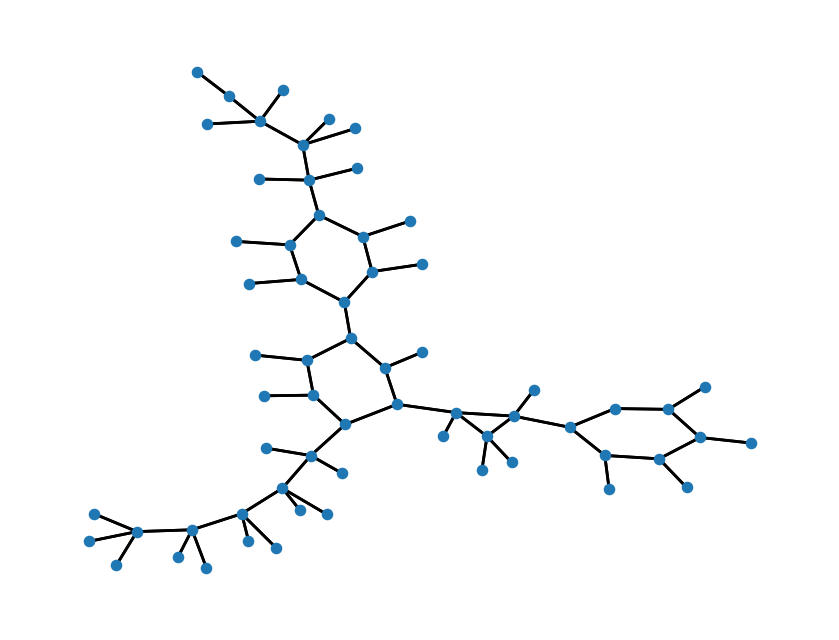

In [401]:
visualize_graph(g)


In [471]:
pdb_coords = residue_df[['x_coord', 'y_coord', 'z_coord']].values # 236 * 3
mol2_coords = mol_df.df[['x', 'y', 'z']].values # 63 * 3
edges = []
edge_weights = []

threshold_distance = 8.0

# Iterate over each residue (protein) and each atom (ligand)
for residue_idx, residue_coord in enumerate(pdb_coords):
    for atom_idx, atom_coord in enumerate(mol2_coords):
        # Calculate Euclidean distance between the residue and atom
        dist = np.linalg.norm(residue_coord - atom_coord)
        
        # Check if the distance is less than 8 Å
        if dist < threshold_distance:
            # Compute the edge weight
            edge_weight = (threshold_distance - dist) / threshold_distance
            
            # Add edge and edge weight
            edges.append((residue_idx, atom_idx))
            edge_weights.append(edge_weight)

edges_df = pd.DataFrame(edges, columns=['residue', 'atom'])
edges_df['weight'] = edge_weights

edges_df

residue  atom    weight
0         55    14  0.001382
1         55    49  0.122782
2         55    61  0.020883
3         73     0  0.183313
4         73     1  0.232650
..       ...   ...       ...
584      216    43  0.224000
585      216    46  0.330381
586      216    49  0.078348
587      216    51  0.255212
588      216    55  0.079287

[589 rows x 3 columns]

In [485]:
ar_edges_df = edges_df[['atom', 'residue', 'weight']]
ar_edges_df.sort_values('atom', inplace=True)
ar_edges_df.reset_index(drop=True, inplace=True)
ar_edges_df

atom  residue    weight
0       0      141  0.303903
1       0      192  0.062107
2       0      190  0.077720
3       0      162  0.377784
4       0      119  0.054213
..    ...      ...       ...
584    62      209  0.318692
585    62      208  0.224540
586    62      192  0.008755
587    62      196  0.218505
588    62      205  0.234512

[589 rows x 3 columns]

In [461]:
mol2_pdb_u = edges_df['residue'].tolist()  # Replace 'residue' with the column name for src nodes
mol2_pdb_v = edges_df['atom'].tolist()     # Replace 'atom' with the column name for dest nodes
edge_weights = edges_df['weight'].tolist()  # Edge weights
edge_weights = torch.tensor(edge_weights, dtype=torch.float32)
g = dgl.graph((mol2_pdb_u, mol2_pdb_v))

In [877]:
complex_names = koff_data_cleaned['ligand name'].str[:-5]

# def get_distance_matrix(coords):
#     diff_tensor = np.expand_dims(coords, axis=1) - np.expand_dims(coords, axis=0)
#     distance_matrix = np.sqrt(np.sum(np.power(diff_tensor, 2), axis=-1))
#     return distance_matrix


graphs_arr = []
graph_labels = []
pdb_graph = None
mol2_graph = None

atomic_numbers = [8, 7, 6, 16, 35, 15, 17, 9, 53, 1]
degrees = [1, 2, 3, 4, 0]
expl_v_arr = [2, 3, 4, 1, 5, 6, 0]
impl_v_arr = [0, 1]
is_aromatic = [0, 1]

# Generate column names for one-hot encoding based on each feature
lig_feat_columns = (
    [f'atom_num_{num}' for num in atomic_numbers] +
    [f'degree_{deg}' for deg in degrees] +
    [f'expl_val_{val}' for val in expl_v_arr] +
    [f'impl_val_{val}' for val in impl_v_arr] +
    [f'aromatic_{arom}' for arom in is_aromatic]
)

j = 0

hetero_graph = None

for i in complex_names[:]:
    
    print(j, i)
    j= j+1
    
    try:
    
        row = koff_data_cleaned[koff_data_cleaned['ligand name'] == f"{i}.mol2"]
    
        pdb_path = f"./koff_dataset/initial_structure/{i}/{i}_protein.pdb"
        atom_df = PandasPdb().read_pdb(pdb_path)
        atom_df = atom_df.df['ATOM']
        residue_df = atom_df.groupby('residue_number', as_index=False)[['x_coord', 'y_coord', 'z_coord']].mean().sort_values('residue_number')

        n_residues = len(atom_df.groupby('residue_number', as_index=False))
        residue_df['norm_position'] = residue_df['residue_number'] / n_residues
        residue_df['residue_name'] = prot_df.groupby('residue_number', as_index=False).first()['residue_name']
        residue_df['residue_name'] = residue_df['residue_name'].map(amino_acid_dict)
        
        df_one_hot = pd.get_dummies(residue_df['residue_name'], prefix='', prefix_sep='')
        residue_df = pd.concat([residue_df, df_one_hot], axis=1)
        res_columns = residue_df['residue_name'].unique()

        df = pd.DataFrame()
        for aa in BLOSUM62.columns:
            # Add a new column for each amino acid in the BLOSUM62 matrix
            df[aa+'_BL'] = residue_df['residue_name'].map(BLOSUM62[aa])
        
        residue_df = pd.concat([residue_df, df], axis=1)
        # print(residue_df)
        
        pdb_coords = residue_df[['x_coord', 'y_coord', 'z_coord']].values
        # pdb_distance_matrix = get_distance_matrix(pdb_coords)
        pdb_distance_matrix = distance_matrix(pdb_coords, pdb_coords)
        pdb_adj = pdb_distance_matrix < 8.0
        pdb_u, pdb_v = np.nonzero(pdb_adj)
        pdb_u, pdb_v = torch.from_numpy(pdb_u), torch.from_numpy(pdb_v)

        pdb_src = torch.cat([pdb_u, pdb_v])
        pdb_dest = torch.cat([pdb_v, pdb_u])
        # pdb_graph = dgl.graph((pdb_u, pdb_v), num_nodes=len(pdb_coords))

        # Protein Node Features
        # pdb_graph.ndata
        # print(graph)
    
        mol2_path = f"./koff_dataset/initial_structure/{i}/{i}.mol2"
        mol_df = PandasMol2().read_mol2(mol2_path)
        mol = Chem.MolFromMol2File(mol2_path, sanitize=True)
        mol = Chem.AddHs(mol)

        lig_feat_df = pd.DataFrame(columns=lig_feat_columns)
        lig_feat_df = lig_feat_df.astype(int)  # Ensure all values are integers
        rows = []
        for atom in mol.GetAtoms():
            # Create a new row initialized to zeros for all columns
            new_row = {col: 0 for col in lig_feat_df.columns}
            
            # Get features of the atom
            atomic_num = atom.GetAtomicNum()
            degree = atom.GetDegree()
            expl_val = atom.GetExplicitValence()
            impl_val = atom.GetImplicitValence()
            is_aromatic = int(atom.GetIsAromatic())
            
            # Set the appropriate one-hot encoded columns to 1 based on atom's features
            # For atomic number
            atomic_col = f'atom_num_{atomic_num}'
            if atomic_col in new_row:
                new_row[atomic_col] = 1
            
            # For degree
            degree_col = f'degree_{degree}'
            if degree_col in new_row:
                new_row[degree_col] = 1
        
            # For explicit valence
            expl_val_col = f'expl_val_{expl_val}'
            if expl_val_col in new_row:
                new_row[expl_val_col] = 1
        
            # For implicit valence
            impl_val_col = f'impl_val_{impl_val}'
            if impl_val_col in new_row:
                new_row[impl_val_col] = 1
        
            # For aromaticity
            aromatic_col = f'aromatic_{is_aromatic}'
            if aromatic_col in new_row:
                new_row[aromatic_col] = 1

            # Append the new row to the list
            rows.append(new_row)

        # Concatenate all rows to the DataFrame at once
        lig_feat_df = pd.concat([lig_feat_df, pd.DataFrame(rows)], ignore_index=True)
        # print(lig_feat_df)

        mol_df.df['symbol'] = mol_df.df['atom_type'].apply(lambda x: x.split(".")[0])
        
        # Concatenate the one-hot encoded columns back to the original DataFrame
        pd.concat([mol_df.df, lig_feat_df], axis=1)

        nodes = []
        edges = []
        bond_features = []
        
        for atom in mol.GetAtoms():
            nodes.append(atom.GetIdx())  # GetIdx() returns the atom index

        # Add each bond as an edge (based on chemical bonds)
        for bond in mol.GetBonds():
            # Get the indices of the atoms connected by the bond
            src = bond.GetBeginAtomIdx()
            dest = bond.GetEndAtomIdx()
        
            bond_feature = {
                'single': 0,
                'double': 0,
                'triple': 0,
                'aromatic': 0,
                'conjugated': 0,
                'ring': 0
            }
        
            b_t = bond.GetBondType()
            if b_t == Chem.BondType.SINGLE:
                bond_feature['single'] = 1
            elif b_t == Chem.BondType.DOUBLE:
                bond_feature['double'] = 1
            elif b_t == Chem.BondType.TRIPLE:
                bond_feature['triple'] = 1
            elif b_t == Chem.BondType.AROMATIC:
                bond_feature['aromatic'] = 1
            if bond.GetIsConjugated():
                bond_feature['conjugated'] = 1
            if bond.IsInRing():
                bond_feature['ring'] = 1
            
            # Add the edge (atom1, atom2) to the list of edges
            edges.append((src, dest))
            edges.append((dest, src))
            bond_features.append(bond_feature)
            bond_features.append(bond_feature)
        
        # print("Nodes:", nodes)
        edges_df = pd.DataFrame(edges, columns=['src', 'dest'])
        bond_features_df = pd.DataFrame(bond_features)
        edges_df = pd.concat([edges_df, bond_features_df], axis=1)

        # print(edges_df)

        a_src = edges_df['src'].tolist()
        a_dest = edges_df['dest'].tolist()

        a_edge_a = edges_df[['single', 'double', 'triple', 'aromatic', 'conjugated', 'ring']].values
        # print(a_edge_a)
            
        
        # mol2_atom_df = mol_df.df[['x', 'y', 'z']]  # You can add more features as needed
        mol2_coords = mol_df.df[['x', 'y', 'z']].values
        # mol2_distance_matrix = get_distance_matrix(mol2_coords)
        # ?????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????
        # Do we need distance matrix, or connect only bonded atoms?
        # mol2_distance_matrix = distance_matrix(mol2_coords, mol2_coords)
        # mol2_adj = mol2_distance_matrix < 8.0
        # mol2_u, mol2_v = np.nonzero(mol2_adj)
        # mol2_u, mol2_v = torch.from_numpy(mol2_u), torch.from_numpy(mol2_v)
        # mol2_graph = dgl.graph((mol2_u, mol2_v), num_nodes=len(mol2_coords))
        # collated_graph = dgl.batch([pdb_graph, mol2_graph])

        # mol2_pdb_distance_matrix = distance_matrix(mol2_coords, pdb_coords)
        # mol2_pdb_adj = mol2_pdb_distance_matrix < 8.0
        # mol2_pdb_u, mol2_pdb_v = np.nonzero(mol2_pdb_adj)
        # mol2_pdb_u, mol2_pdb_v = torch.from_numpy(mol2_pdb_u), torch.from_numpy(mol2_pdb_v)
        
        # pdb_mol2_distance_matrix = distance_matrix(pdb_coords, mol2_coords)
        # pdb_mol2_adj = pdb_mol2_distance_matrix < 8.0
        # pdb_mol2_u, pdb_mol2_v = np.nonzero(pdb_mol2_adj)
        # pdb_mol2_u, pdb_mol2_v = torch.from_numpy(pdb_mol2_u), torch.from_numpy(pdb_mol2_v)

        edges = []
        edge_weights = []
        
        threshold_distance = 8.0
        
        # Iterate over each residue (protein) and each atom (ligand)
        for residue_idx, residue_coord in enumerate(pdb_coords):
            for atom_idx, atom_coord in enumerate(mol2_coords):
                # Calculate Euclidean distance between the residue and atom
                dist = np.linalg.norm(residue_coord - atom_coord)
                
                # Check if the distance is less than 8 Å
                if dist < threshold_distance:
                    # Compute the edge weight
                    edge_weight = (threshold_distance - dist) / threshold_distance
                    
                    # Add edge and edge weight
                    edges.append((residue_idx, atom_idx))
                    edge_weights.append(edge_weight)

        # residue_to_atom
        # print(pdb_coords)
        edges_df = pd.DataFrame(edges, columns=['residue', 'atom'])
        edges_df['weight'] = edge_weights
        # print(edges_df)

        # atom_to_residue
        ar_edges_df = edges_df[['atom', 'residue', 'weight']]
        # ar_edges_df.sort_values('atom', inplace=True)
        # ar_edges_df.reset_index(drop=True, inplace=True)
        # print(ar_edges_df)
    
        # Find out a correct way to add these following features to the graph
        ###collated_graph.ndata['method_onehot'] = torch.tensor(np.fromstring(row['method_onehot'].values[0].strip('[]'), sep=' '), dtype=torch.float32)
        ###collated_graph.ndata['protein_type_onehot'] = torch.tensor(np.fromstring(row['protein_type_onehot'].values[0].strip('[]'), sep=' '), dtype=torch.float32)
    
        # koff_main as the target (graph label)
        target = row['koff_main'].values[0]
        graph_labels.append(target)
        
        # print(collated_graph)
        # print('--------\n')

        graph_data_dict = {
            ('atom', 'a_conn', 'atom'): (torch.tensor(a_src), torch.tensor(a_dest)),
            ('atom', 'int_r', 'residue'): (torch.tensor(edges_df['atom'].values), torch.tensor(edges_df['residue'].values)),
            ('residue', 'int_l', 'atom'): (torch.tensor(edges_df['residue'].values), torch.tensor(edges_df['atom'].values)),
            ('residue', 'r_conn', 'residue'): (pdb_src, pdb_dest)
        }

        hetero_graph = dgl.heterograph(graph_data_dict)
        # print(hetero_graph)
        hetero_graph.ndata['feat'] = {
            'atom': torch.tensor(lig_feat_df.values, dtype=torch.float32),
            'residue': torch.tensor(residue_df[residue_columns].values, dtype=torch.float32)
        }
        hetero_graph.edata['feat'] = {
            ('atom', 'a_conn', 'atom'): torch.tensor(a_edge_a, dtype=torch.float32)
        }
        hetero_graph.edata['weight'] = {
            ('atom', 'int_r', 'residue'): torch.tensor(ar_edges_df['weight'].values, dtype=torch.float32),
            ('residue', 'int_l', 'atom'): torch.tensor(edges_df['weight'].values, dtype=torch.float32)
        }

        graphs_arr.append(hetero_graph)
        

        
        
    except Exception as e: 
        # To see which complexes are corrupted. As a result complexes on rows [365, 366, 369, 379-388, 397-399, 413, 418, 419, 444, 445, 475, 476] are erroneous
        print("*************************\n*************************\n*************************")
        # raise 

# print('Lig Feat DF:')
# hetero_graph
# Convert the labels to a tensor
# graph_labels = torch.stack(graph_labels)
# koff_labels = torch.tensor(koff_data_cleaned['koff_main'].values, dtype=torch.float32)


# dgl.save_graphs('graphs_arr.bin', graphs_arr, {'labels': koff_labels})
dgl.save_graphs('graphs_arr.bin', graphs_arr)
print("Graphs and labels saved to 'graphs_arr.bin'")

0 1d4h_ligand_native_749
1 1d4i_ligand_native_771
2 1df8_ligand_native_359
3 1ebw_ligand_a015_762_dock
4 1ebw_ligand_a016_761_dock
5 1ebw_ligand_a017_760_dock
6 1ebw_ligand_a018_764_dock
7 1ebw_ligand_b249_768_dock
8 1ebw_ligand_b268_757_dock
9 1ebw_ligand_b277_758_dock
10 1ebw_ligand_b322_765_dock
11 1ebw_ligand_b347_767_dock
12 1ebw_ligand_b365_766_dock
13 1ebw_ligand_b376_763_dock
14 1ebw_ligand_b408_759_dock
15 1eby_ligand_b388_770_dock
16 1eby_ligand_native_769
17 1ec1_ligand_b440_751_dock
18 1ec1_ligand_native_750
19 1ec2_ligand_a037_754_dock
20 1ec2_ligand_a038_756_dock
21 1ec2_ligand_b412_753_dock
22 1ec2_ligand_b429_752_dock
23 1ec2_ligand_b439_755_dock
24 1efc_ligand_GTPYs_690_dock
25 1efc_ligand_native_689
26 1g2k_ligand_a045_774_dock
27 1g2k_ligand_native_773
28 1g35_ligand_a008_776_dock
29 1g35_ligand_a021_777_dock
30 1g35_ligand_a023_779_dock
31 1g35_ligand_a030_778_dock
32 1g35_ligand_native_775
33 1hiv_ligand_b295_781_dock
34 1hiv_ligand_b355_782_dock
35 1hiv_ligand_u75

[23:32:10] WARNING: not removing hydrogen atom without neighbors


147 4gu6_ligand_37_84_dock
148 4gu6_ligand_39_85_dock
149 4gu6_ligand_41_86_dock
150 4gu6_ligand_42_87_dock
151 4gu6_ligand_44_88_dock
152 4gu6_ligand_45_89_dock


[23:32:11] WARNING: not removing hydrogen atom without neighbors


153 4gu6_ligand_47_90_dock1
154 4gu6_ligand_48_91_dock
155 4gu6_ligand_49_92_dock
156 4gu6_ligand_50_93_dock


[23:32:11] WARNING: not removing hydrogen atom without neighbors


157 4gu6_ligand_native_76
158 4hu1_ligand_native_687
159 4k9y_ligand_native_94
160 4kao_ligand_16_95_dock
161 4kao_ligand_17_96_dock
162 4kao_ligand_18_97_dock
163 4kao_ligand_19_98_dock
164 4kao_ligand_20_99_dock
165 4kao_ligand_21_100_dock
166 4kao_ligand_22_101_dock
167 4kao_ligand_23_102_dock
168 4kao_ligand_25_104_dock
169 4kao_ligand_26_105_dock
170 4kao_ligand_28_107_dock
171 4kao_ligand_29_108_dock
172 4kao_ligand_30_109_dock
173 4kao_ligand_native_106
174 4ksp_ligand_native_415
175 4ly1_ligand_2_227_dock
176 4ly1_ligand_MS275_226_dock
177 4ly1_ligand_TSA_228_dock
178 4ly1_ligand_native_225
179 4nks_ligand_native_294
180 4obe_ligand_native_663
181 4og8_ligand_native_662
182 4oiv_ligand_native_423
183 4p4c_ligand_11d_362_dock1
184 4p5z_ligand_native_361
185 4pmm_ligand_11_238_dock
186 4pmm_ligand_native_235
187 4pmp_ligand_17_239_dock
188 4pmp_ligand_native_236
189 4pms_ligand_23_240_dock
190 4pms_ligand_native_237
191 4qta_ligand_native_647
192 4s0v_ligand_native_685
193 4u15_l

In [890]:
graphs_arr[300].ndata['feat']['residue'].shape

torch.Size([360, 41])

In [894]:
graphs_arr[0].edata['weight']

{('atom',
  'int_r',
  'residue'): tensor([0.2737, 0.0150, 0.1296, 0.2776, 0.2321, 0.0400, 0.1332, 0.0534, 0.2688,
         0.1056, 0.0338, 0.1227, 0.3908, 0.3025, 0.1045, 0.1507, 0.0069, 0.0835,
         0.2419, 0.0421, 0.1941, 0.0594, 0.2944, 0.2156, 0.0464, 0.0811, 0.0995,
         0.0634, 0.2510, 0.3311, 0.2066, 0.3898, 0.1400, 0.4122, 0.1075, 0.0197,
         0.2107, 0.0640, 0.2595, 0.0717, 0.0804, 0.0935, 0.0850, 0.0240, 0.2823,
         0.1669, 0.1031, 0.1666, 0.1983, 0.5275, 0.1534, 0.1048, 0.0591, 0.0219,
         0.2746, 0.3530, 0.1259, 0.1667, 0.1658, 0.3160, 0.0608, 0.2139, 0.2788,
         0.1464, 0.1954, 0.0478, 0.2097, 0.5634, 0.2952, 0.3812, 0.1311, 0.3667,
         0.4029, 0.0542, 0.0359, 0.1773, 0.0179, 0.0677, 0.2056, 0.3241, 0.1363,
         0.0491, 0.1679, 0.3553, 0.0269, 0.4497, 0.2922, 0.3005, 0.1580, 0.4780,
         0.1854, 0.5684, 0.4034, 0.4616, 0.3298, 0.5183, 0.0348, 0.1135, 0.1549,
         0.0416, 0.1231, 0.1652, 0.4151, 0.0881, 0.0115, 0.2135, 0.4054, 0.

In [639]:
str_arr = np.array([
     '3ry2_ligand_native_360',
     '4acd_ligand_native_630',
     '4ach_ligand_native_631',
     '4nk9_ligand_native_292',
     '4nka_ligand_native_293',
     '4pf9_ligand_native_412',
     '4pfc_ligand_native_413',
     '5a3o_ligand_1_323_dock1',
     '5a3o_ligand_2_324_dock1',
     '5a3o_ligand_7b_325_dock1',
     '5a3o_ligand_native_322',
     '5eqy_ligand_49_204_dock',
     '5eqy_ligand_66_205_dock',
     '5eqy_ligand_67_206_dock',
     '5eqy_ligand_68_207_dock',
     '5eqy_ligand_69_208_dock',
     '5eqy_ligand_70_209_dock2',
     '5eqy_ligand_native_203',
     '5mes_ligand_12_177_dock1_moe',
     '5mes_ligand_13_178_dock1_moe',
     '5mes_ligand_14_179_dock1_moe',
     '5mes_ligand_native_181',
     '5n1z_ligand_native_213_dock1_5n21_2chains',
     '5n21_ligand_10_212_dock1_5n21_2chains',
     '5n21_ligand_12_214_dock1_5n21_2chains',
     '5n21_ligand_21_215_dock1_5n21_2chains',
     '5n21_ligand_25_216_dock1_5n21_2chains_moe',
     '5n21_ligand_8_211_dock1_5n21_2chains',
     '5n21_ligand_native_210_5n21_2chians',
     '5tx5_ligand_native_444',
     '5zdp_ligand_native_721',
     '5zdr_ligand_asco_722_dock',
     '6cve_ligand_native_705',
     '6npp_ligand_0941_735_dock'
    ])

str_arr = [i + '.mol2' for i in str_arr]
str_arr

['3ry2_ligand_native_360.mol2',
 '4acd_ligand_native_630.mol2',
 '4ach_ligand_native_631.mol2',
 '4nk9_ligand_native_292.mol2',
 '4nka_ligand_native_293.mol2',
 '4pf9_ligand_native_412.mol2',
 '4pfc_ligand_native_413.mol2',
 '5a3o_ligand_1_323_dock1.mol2',
 '5a3o_ligand_2_324_dock1.mol2',
 '5a3o_ligand_7b_325_dock1.mol2',
 '5a3o_ligand_native_322.mol2',
 '5eqy_ligand_49_204_dock.mol2',
 '5eqy_ligand_66_205_dock.mol2',
 '5eqy_ligand_67_206_dock.mol2',
 '5eqy_ligand_68_207_dock.mol2',
 '5eqy_ligand_69_208_dock.mol2',
 '5eqy_ligand_70_209_dock2.mol2',
 '5eqy_ligand_native_203.mol2',
 '5mes_ligand_12_177_dock1_moe.mol2',
 '5mes_ligand_13_178_dock1_moe.mol2',
 '5mes_ligand_14_179_dock1_moe.mol2',
 '5mes_ligand_native_181.mol2',
 '5n1z_ligand_native_213_dock1_5n21_2chains.mol2',
 '5n21_ligand_10_212_dock1_5n21_2chains.mol2',
 '5n21_ligand_12_214_dock1_5n21_2chains.mol2',
 '5n21_ligand_21_215_dock1_5n21_2chains.mol2',
 '5n21_ligand_25_216_dock1_5n21_2chains_moe.mol2',
 '5n21_ligand_8_211_dock

In [643]:
new_dataset_after_dropping = koff_data_cleaned[~koff_data_cleaned['ligand name'].isin(str_arr)]
new_dataset_after_dropping.reset_index(inplace=True, drop=True)
new_dataset_after_dropping

pdbcode                           ligand name                                      method                                       protein type                                             smiles     koff_main                                      method_onehot                                protein_type_onehot
0      1d4h           1d4h_ligand_native_749.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C(NCc1ccccc1)C(OCc1ccccc1)C(O)C(O)C(OCc1cccc...  6.530000e-03  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
1      1d4i           1d4i_ligand_native_771.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C(NC1C(O)Cc2c1cccc2)C(OCc1ccccc1)C(O)CC(OCc1...  2.340000e-01  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
2      1df8           1df8_ligand_native_359.mol2              radioligand_displacement_assay                                       streptavidin                      O=C([O-])CCCCC1SCC2NC(=O)NC12  5.000000e-02  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
3      1ebw        1ebw_ligand_a015_762_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...  9.380000e-01  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
4      1ebw        1ebw_ligand_a016_761_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...  6.050000e-02  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
5      1ebw        1ebw_ligand_a017_760_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...  1.790000e-01  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
6      1ebw        1ebw_ligand_a018_764_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  S(CCC(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1ccccc1...  4.740000e-01  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
7      1ebw        1ebw_ligand_b249_768_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C(OC)C(NC(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1cccc...  2.730000e-01  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
8      1ebw        1ebw_ligand_b268_757_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C(NC(C(=O)NC)C(C)C)C(OCc1ccccc1)C(O)C(O)C(OC...  3.670000e-03  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
9      1ebw        1ebw_ligand_b277_758_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C(NC(C(=O)NC)C(C)C)C(OCCC)C(O)C(O)C(OCCC)C(=...  4.850000e-03  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
10     1ebw        1ebw_ligand_b322_765_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...  6.770000e-02  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
11     1ebw        1ebw_ligand_b347_767_dock.mol2                   surface_plasmon_resonance                                     hiv_1_protease  O=C([O-])C(N(C(=O)C(OCc1ccccc1)C(O)C(O)C(OCc1c...  2.700000e-02  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

In [644]:
new_dataset_after_dropping.to_csv("koff_data_cleaned2.csv", index=False)

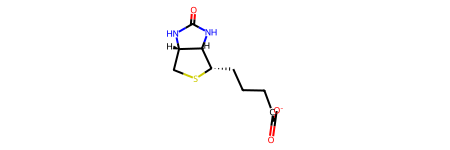

In [596]:
mol

In [582]:
graphs_arr

[Graph(num_nodes={'atom': 83, 'residue': 198},
       num_edges={('atom', 'a_conn', 'atom'): 174, ('atom', 'int_r', 'residue'): 928, ('residue', 'int_l', 'atom'): 928, ('residue', 'r_conn', 'residue'): 4392},
       metagraph=[('atom', 'atom', 'a_conn'), ('atom', 'residue', 'int_r'), ('residue', 'atom', 'int_l'), ('residue', 'residue', 'r_conn')]),
 Graph(num_nodes={'atom': 87, 'residue': 198},
       num_edges={('atom', 'a_conn', 'atom'): 184, ('atom', 'int_r', 'residue'): 967, ('residue', 'int_l', 'atom'): 967, ('residue', 'r_conn', 'residue'): 4376},
       metagraph=[('atom', 'atom', 'a_conn'), ('atom', 'residue', 'int_r'), ('residue', 'atom', 'int_l'), ('residue', 'residue', 'r_conn')]),
 Graph(num_nodes={'atom': 31, 'residue': 127},
       num_edges={('atom', 'a_conn', 'atom'): 64, ('atom', 'int_r', 'residue'): 12, ('residue', 'int_l', 'atom'): 12, ('residue', 'r_conn', 'residue'): 17598},
       metagraph=[('atom', 'atom', 'a_conn'), ('atom', 'residue', 'int_r'), ('residue', 'at

In [397]:
def visualize_graph(graph):
    nx_graph = dgl.to_networkx(graph)
    plt.figure(figsize=(4, 3), dpi=200)
    nx.draw(nx_graph, pos=nx.kamada_kawai_layout(nx_graph), node_size=10, arrows=False, width=1)
    plt.show()

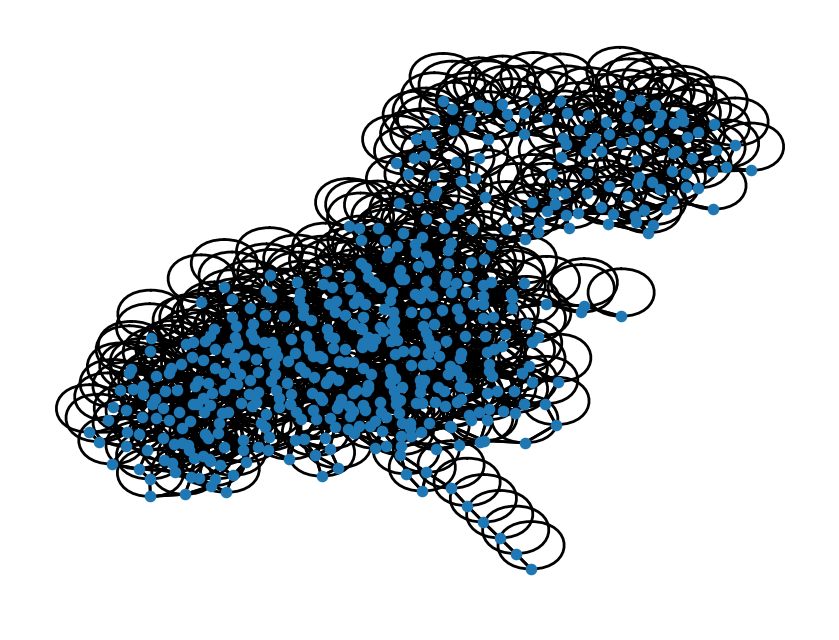

In [617]:
visualize_graph(pdb_graph)

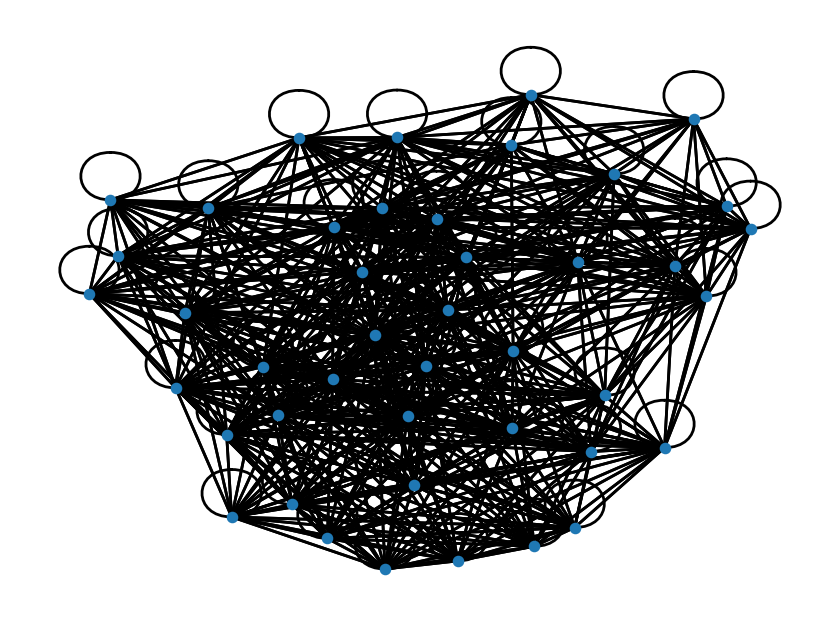

In [619]:
visualize_graph(mol2_graph)

In [620]:
dgl.save_graphs("dgl_graphs.bin", graphs_arr)
graphs_arr = dgl.load_graphs("dgl_graphs.bin")

In [551]:
koff_data_cleaned['koff_main']

0      0.00653
1      0.23400
2      0.05000
3      0.93800
4      0.06050
        ...   
452    0.02500
453    0.06700
454    0.00012
455    0.00006
456    0.00100
Name: koff_main, Length: 457, dtype: float64

In [554]:
complex_names

0         1d4h_ligand_native_749
1         1d4i_ligand_native_771
2         1df8_ligand_native_359
3      1ebw_ligand_a015_762_dock
4      1ebw_ligand_a016_761_dock
                 ...            
452      6pgd_ligand_59_710_dock
453       6pgd_ligand_native_709
454       6rln_ligand_native_732
455       6slg_ligand_native_646
456       6un1_ligand_native_731
Name: ligand name, Length: 457, dtype: object

In [653]:
c = element('S')
print('Bondi: ', c.vdw_radius_bondi / 100)
print("None:  ", c.vdw_radius / 100)

Bondi:  1.8
None:   1.8


In [658]:
atomic_numbers

[8, 7, 6, 16, 35, 15, 17, 9, 53, 1]

In [663]:
vdw_radii = {
    i: (element(i).vdw_radius/100) for i in atomic_numbers
}
vdw_radii

{8: 1.52,
 7: 1.55,
 6: 1.7,
 16: 1.8,
 35: 1.85,
 15: 1.8,
 17: 1.75,
 9: 1.47,
 53: 1.98,
 1: 1.1}

In [664]:
# AutoDock Vina weights
weights = {
    "w1": -0.0356,
    "w2": -0.00516,
    "w3": 0.840,
    "w4": -0.0351,
    "w5": -0.587,
    "w6": 0.0585
}

In [915]:
from rdkit.Chem import rdMolDescriptors

N_rot = rdMolDescriptors.\
        CalcNumRotatableBonds(mol)
print("(N_rot):", N_rot) # e.g. 9, 5, 7 etc.

(N_rot): 9


In [719]:
symbol_to_atomic_number = {
    'N': 7,
    'C': 6,
    'O': 8,
    'H': 1,
    'S': 16,
    '': 0,  # Using 0 as a placeholder for empty values,
    'Cl': 17,
    'P': 15,
    'F': 9,
    'Br': 35,
    'I': 53
}

In [765]:
# Define weights from AutoDock Vina
weights = [-0.0356, -0.00516, 0.840, -0.0351, -0.587, 0.0585]

# Define Van der Waals radii
vdw_radii = {8: 1.52, 7: 1.55, 6: 1.7, 16: 1.8, 35: 1.85, 15: 1.8, 17: 1.75, 9: 1.47, 53: 1.98, 1: 1.1, 0: 0}

def calculate_vina_terms(protein_atoms, ligand_atoms, n_rot):
    # protein_atoms and ligand_atoms should be arrays with [(x, y, z, atom_type)]
    
    gauss1, gauss2, repulsion, hydrophobic, hbonding = 0, 0, 0, 0, 0
    flexibility = weights[5] * n_rot
    
    for i in range(len(protein_atoms)): # i
        prot = protein_atoms[i]
        xi, yi, zi, ti = prot
        for j in range(len(ligand_atoms)): # j
            lig = ligand_atoms[j]
            xj, yj, zj, tj = lig
            rij = np.linalg.norm([xi - xj, yi - yj, zi - zj])

            # Apply cutoff of 8 Å
            if rij > threshold_distance:
                continue
            
            dij = rij - vdw_radii[ti] - vdw_radii[tj]
            
            # Gaussian 1
            gauss1 += weights[0] * np.exp(-(dij / 0.5) ** 2)
            
            # Gaussian 2
            gauss2 += weights[1] * np.exp(-((dij - 3) / 2) ** 2)
            
            # Repulsion
            if dij < 0:
                repulsion += weights[2] * (dij ** 2)
            
            # Hydrophobic
            if 0.5 < dij < 1.5:
                hydrophobic += weights[3] * (1.5 - dij)
            elif dij <= 0.5:
                hydrophobic += weights[3]
                
            # H-bonding
            if -0.7 < dij < 0:
                hbonding += weights[4] * (dij / -0.7)
            elif dij <= -0.7:
                hbonding += weights[4]
    
    return np.array([gauss1, gauss2, repulsion, hydrophobic, hbonding, flexibility], dtype=np.float32)


In [766]:
cutoff_distance = threshold_distance
atom_types_in_pdb = []
vina_dict = {}

j = 0

for i in complex_names:
    
    print(j, i)
    j= j+1

    
    pdb_path = f"./koff_dataset/initial_structure/{i}/{i}_protein.pdb"
    atom_df = PandasPdb().read_pdb(pdb_path)
    atom_df = atom_df.df['ATOM']
    residue_df = atom_df.groupby('residue_number', as_index=False)[['x_coord', 'y_coord', 'z_coord']].mean().sort_values('residue_number')
    # print(residue_df)
    
    pdb_coords = residue_df[['x_coord', 'y_coord', 'z_coord']].values
    # pdb_distance_matrix = get_distance_matrix(pdb_coords)

    pdb_src = torch.cat([pdb_u, pdb_v])
    pdb_dest = torch.cat([pdb_v, pdb_u])
    mol2_path = f"./koff_dataset/initial_structure/{i}/{i}.mol2"
    mol_df = PandasMol2().read_mol2(mol2_path).df
    mol2_coords = mol_df[['x','y','z']].values
    mol = Chem.MolFromMol2File(mol2_path, sanitize=True)
    N_rot = rdMolDescriptors.CalcNumRotatableBonds(mol)
    
    pdb_mol2_dist_matrix = distance_matrix(pdb_coords, mol2_coords)

    atoms_in_pdb = []
    for k in atom_df['atom_name'].values:
        arr = [*k]
        symbol = ''
        if len(arr) == 0:
            print('ERROR: ' + k)
        elif len(arr) == 1:
            symbol = arr[0]
        elif len(arr) >= 2:
            if arr[1].isupper():
                symbol = arr[0]
            elif arr[1].islower():
                symbol = f"{arr[0]}{arr[1]}"

        if symbol == "":
            print("+++++++++\n+++++++++")
        if symbol not in atom_types_in_pdb:
            atom_types_in_pdb.append(symbol)
        atoms_in_pdb.append(symbol)
    
    atomic_numbers_array = np.vectorize(symbol_to_atomic_number.get)(atoms_in_pdb)
    atom_df['symbol'] = atoms_in_pdb
    atom_df['atomic_number'] = atomic_numbers_array

    mol_df['atomic_number'] = [symbol_to_atomic_number[i.split('.')[0]] for i in mol_df['atom_type'].values]

    aaaa = atom_df[['x_coord', 'y_coord', 'z_coord', 'atomic_number']].values
    bbbb = mol_df[['x','y', 'z', 'atomic_number']].values
    vina_dict[i] = calculate_vina_terms(aaaa, bbbb, N_rot)
    

vina_dict

0 1d4h_ligand_native_749
1 1d4i_ligand_native_771
2 1df8_ligand_native_359
3 1ebw_ligand_a015_762_dock
4 1ebw_ligand_a016_761_dock
5 1ebw_ligand_a017_760_dock
6 1ebw_ligand_a018_764_dock
7 1ebw_ligand_b249_768_dock
8 1ebw_ligand_b268_757_dock
9 1ebw_ligand_b277_758_dock
10 1ebw_ligand_b322_765_dock
11 1ebw_ligand_b347_767_dock
12 1ebw_ligand_b365_766_dock
13 1ebw_ligand_b376_763_dock
14 1ebw_ligand_b408_759_dock
15 1eby_ligand_b388_770_dock
16 1eby_ligand_native_769
17 1ec1_ligand_b440_751_dock
18 1ec1_ligand_native_750
19 1ec2_ligand_a037_754_dock
20 1ec2_ligand_a038_756_dock
21 1ec2_ligand_b412_753_dock
22 1ec2_ligand_b429_752_dock
23 1ec2_ligand_b439_755_dock
24 1efc_ligand_GTPYs_690_dock
25 1efc_ligand_native_689
26 1g2k_ligand_a045_774_dock
27 1g2k_ligand_native_773
28 1g35_ligand_a008_776_dock
29 1g35_ligand_a021_777_dock
30 1g35_ligand_a023_779_dock
31 1g35_ligand_a030_778_dock
32 1g35_ligand_native_775
33 1hiv_ligand_b295_781_dock
34 1hiv_ligand_b355_782_dock
35 1hiv_ligand_u75

[17:17:12] WARNING: not removing hydrogen atom without neighbors


147 4gu6_ligand_37_84_dock
148 4gu6_ligand_39_85_dock
149 4gu6_ligand_41_86_dock
150 4gu6_ligand_42_87_dock
151 4gu6_ligand_44_88_dock
152 4gu6_ligand_45_89_dock


[17:17:20] WARNING: not removing hydrogen atom without neighbors


153 4gu6_ligand_47_90_dock1
154 4gu6_ligand_48_91_dock
155 4gu6_ligand_49_92_dock


[17:17:23] WARNING: not removing hydrogen atom without neighbors


156 4gu6_ligand_50_93_dock
157 4gu6_ligand_native_76
158 4hu1_ligand_native_687
159 4k9y_ligand_native_94
160 4kao_ligand_16_95_dock
161 4kao_ligand_17_96_dock
162 4kao_ligand_18_97_dock
163 4kao_ligand_19_98_dock
164 4kao_ligand_20_99_dock
165 4kao_ligand_21_100_dock
166 4kao_ligand_22_101_dock
167 4kao_ligand_23_102_dock
168 4kao_ligand_25_104_dock
169 4kao_ligand_26_105_dock
170 4kao_ligand_28_107_dock
171 4kao_ligand_29_108_dock
172 4kao_ligand_30_109_dock
+++++++++
+++++++++
+++++++++
+++++++++
+++++++++
+++++++++
173 4kao_ligand_native_106
174 4ksp_ligand_native_415
175 4ly1_ligand_2_227_dock
176 4ly1_ligand_MS275_226_dock
177 4ly1_ligand_TSA_228_dock
178 4ly1_ligand_native_225
179 4nks_ligand_native_294
180 4obe_ligand_native_663
181 4og8_ligand_native_662
182 4oiv_ligand_native_423
183 4p4c_ligand_11d_362_dock1
184 4p5z_ligand_native_361
185 4pmm_ligand_11_238_dock
186 4pmm_ligand_native_235
187 4pmp_ligand_17_239_dock
188 4pmp_ligand_native_236
+++++++++
+++++++++
+++++++++
++

{'1d4h_ligand_native_749': array([ -6.7087502, -44.035614 ,   3.507702 , -20.9034   ,  -7.4358044,
          0.819    ], dtype=float32),
 '1d4i_ligand_native_771': array([ -6.8572345, -45.64153  ,   2.6893566, -21.98296  ,  -6.3071585,
          0.7605   ], dtype=float32),
 '1df8_ligand_native_359': array([ -3.2516139, -17.944756 ,   4.335962 , -10.295662 ,  -6.047463 ,
          0.2925   ], dtype=float32),
 '1ebw_ligand_a015_762_dock': array([ -9.32498  , -47.121098 ,   2.8835745, -23.651941 , -10.307816 ,
          1.1115   ], dtype=float32),
 '1ebw_ligand_a016_761_dock': array([ -9.737796, -48.677235,   4.626297, -24.561586, -13.924094,
          1.1115  ], dtype=float32),
 '1ebw_ligand_a017_760_dock': array([ -6.985351 , -42.55326  ,   3.8293235, -19.335445 ,  -9.910349 ,
          0.9945   ], dtype=float32),
 '1ebw_ligand_a018_764_dock': array([ -7.4399037, -43.02855  ,   1.0718694, -19.676146 ,  -4.6805587,
          1.2285   ], dtype=float32),
 '1ebw_ligand_b249_768_dock': array

In [767]:
import pickle

In [846]:
f = open("Vina_terms.pkl","wb")
pickle.dump(vina_dict,f)
f.close()

In [743]:
aaaa = atom_df[['x_coord', 'y_coord', 'z_coord', 'atomic_number']].values

ValueError: too many values to unpack (expected 2)

In [753]:
for aa in aaaa[:3]:
    print(aa)
    aa, ad, ag, af = aa
    print (aa)

[29.036 40.209  5.274  7.   ]
29.036
[29.954 39.15   4.808  6.   ]
29.954
[29.334 38.35   3.672  6.   ]
29.334


In [757]:
bbbb = mol_df[['x','y', 'z', 'atomic_number']].values

In [758]:
calculate_vina_terms(aaaa, bbbb, 8)

array([ -6.7087502, -51.454533 ,   3.507702 , -13.462201 ,  -6.2618046,
         0.468    ], dtype=float32)

In [706]:
np.vectorize(symbol_to_atomic_number.get)(atoms_in_pdb)

array([7, 6, 6, ..., 1, 1, 1])

In [732]:
mol_df

atom_id atom_name        x        y        z atom_type  subst_id subst_name  charge  atomic_number
0         1        O1  10.7420  23.5120   6.0230       O.2         1        UNK     0.0              8
1         2        O2  14.2250  20.4730   6.1690       O.2         1        UNK     0.0              8
2         3        O3  19.0070  19.9050   5.4410       O.3         1        UNK     0.0              8
3         4        O4  14.3870  25.2310   4.4320       O.3         1        UNK     0.0              8
4         5        O5  14.3650  22.6670   3.6600       O.3         1        UNK     0.0              8
5         6        O6  11.8090  23.5440   3.2680       O.3         1        UNK     0.0              8
6         7        O7  14.5170  23.0660   7.3690       O.3         1        UNK     0.0              8
7         8        N8  10.0410  25.5750   5.3910      N.am         1        UNK     0.0              7
8         9        N9  16.3950  20.7770   5.5250      N.am         1        UNK     0.0              7
9        10       C10  11.1600  24.0600   2.0790       C.3         1        UNK     0.0              6
10       11       C11  15.6190  23.4100   8.2480       C.3         1        UNK     0.0              6
11       12       C12   6.7800  24.4030   2.4590      C.ar         1        UNK     0.0              6
12       13       C13  17.6090  19.7970   9.7840      C.ar         1        UNK     0.0              6
13       14       C14   8.8720  28.4340   9.5710      C.ar         1        UNK     0.0              6
14       15       C15   7.5430  25.5030   1.9360      C.ar         1        UNK     0.0              6
15       16       C16   7.4370  23.1770   2.8360      C.ar         1        UNK     0.0              6
16       17       C17  16.2100  20.0020  10.0420      C.ar         1        UNK     0.0              6
17       18       C18  18.3730  20.7890   9.0700      C.ar         1        UNK     0.0              6
18       19       C19   7.7190  28.2790   8.7250      C.ar         1        UNK     0.0              6
19       20       C20  10.0540  27.6410   9.3460      C.ar         1        UNK     0.0              6
20       21       C21  16.8120  17.7130   1.3370      C.ar         1        UNK     0.0              6
21       22       C22  15.8260  18.7360   1.5760      C.ar         1        UNK     0.0              6
22       23       C23   8.9490  25.5690   6.3440       C.3         1        UNK     0.0              6
23       24       C24   8.9720  25.3820   1.7890      C.ar         1        UNK     0.0              6
24       25       C25   8.8640  23.0480   2.6930      C.ar         1        UNK     0.0              6
25       26       C26  15.5640  21.2040   9.5830      C.ar         1        UNK     0.0              6
26       27       C27  17.7390  21.9900   8.6030      C.ar         1        UNK     0.0              6
27       28       C28   7.7390  27.3260   7.6450      C.ar         1        UNK     0.0              6
28       29       C29  10.0840  26.6870   8.2700      C.ar         1        UNK     0.0              6
29       30       C30  17.6910  17.2750   2.3880      C.ar         1        UNK     0.0              6
30       31       C31  15.7100  19.3340   2.8860      C.ar         1        UNK     0.0              6
31       32       C32  18.3590  17.6050   4.9160       C.3         1        UNK     0.0              6
32       33       C33  10.9120  24.5110   5.3070       C.2         1        UNK     0.0              6
33       34       C34  15.1550  21.2440   5.9140       C.2         1        UNK     0.0              6
34       35       C35  18.0710  18.8740   5.7570       C.3         1        UNK     0.0              6
35       36       C36  13.3530  24.3940   5.0200       C.3         1        UNK     0.0              6
36       37       C37  13.8830  22.9830   5.0040       C.3         1        UNK     0.0              6
37       38       C38   9.6430  24.1590   2.1710      C.ar         1        UNK     0.0   

In [722]:
len([symbol_to_atomic_number[i.split('.')[0]] for i in mol_df['atom_type'].values])

83

In [716]:
atom_df = atom_df['x_coord'].values

In [717]:
atom_df

array([29.036, 29.954, 29.334, ..., 25.892, 24.842, 25.88 ])

In [786]:
labels_table = koff_data_cleaned[['ligand name','koff_main']]

In [787]:
labels_table['ligand name'] = labels_table['ligand name'].str[:-5].values

/var/folders/xy/z950zcv53kn7fmy0fzz973l00000gn/T/ipykernel_97206/164385243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_table['ligand name'] = labels_table['ligand name'].str[:-5].values


In [843]:
labels_table = labels_table.rename(columns={'ligand name': 'id', 'koff_main':'koff'})

In [844]:
labels_table

id          koff
0             1d4h_ligand_native_749  6.530000e-03
1             1d4i_ligand_native_771  2.340000e-01
2             1df8_ligand_native_359  5.000000e-02
3          1ebw_ligand_a015_762_dock  9.380000e-01
4          1ebw_ligand_a016_761_dock  6.050000e-02
5          1ebw_ligand_a017_760_dock  1.790000e-01
6          1ebw_ligand_a018_764_dock  4.740000e-01
7          1ebw_ligand_b249_768_dock  2.730000e-01
8          1ebw_ligand_b268_757_dock  3.670000e-03
9          1ebw_ligand_b277_758_dock  4.850000e-03
10         1ebw_ligand_b322_765_dock  6.770000e-02
11         1ebw_ligand_b347_767_dock  2.700000e-02
12         1ebw_ligand_b365_766_dock  3.090000e-02
13         1ebw_ligand_b376_763_dock  1.370000e+01
14         1ebw_ligand_b408_759_dock  1.690000e-03
15         1eby_ligand_b388_770_dock  2.270000e-02
16            1eby_ligand_native_769  1.330000e-02
17         1ec1_ligand_b440_751_dock  3.000000e-04
18            1ec1_ligand_native_750  4.300000e-04
19         1ec2_ligand_a037_754_dock  3.700000e-04
20         1ec2_ligand_a038_756_dock  4.900000e-04
21         1ec2_ligand_b412_753_dock  8.200000e-04
22         1ec2_ligand_b429_752_dock  3.700000e-04
23         1ec2_ligand_b439_755_dock  1.630000e-03
24        1efc_ligand_GTPYs_690_dock  3.800000e-02
25            1efc_ligand_native_689  1.700000e-03
26         1g2k_ligand_a045_774_dock  2.630000e-01
27            1g2k_ligand_native_773  6.970000e-02
28         1g35_ligand_a008_776_dock  4.380000e+01
29         1g35_ligand_a021_777_dock  2.730000e-02
30         1g35_ligand_a023_779_dock  1.390000e-01
31         1g35_ligand_a030_778_dock  4.200000e-02
32            1g35_ligand_native_775  6.850000e-02
33         1hiv_ligand_b295_781_dock  4.360000e-01
34         1hiv_ligand_b355_782_dock  3.730000e-01
35       1hiv_ligand_u75875_780_dock  5.440000e-03
36            1hxw_ligand_native_784  2.160000e-03
37              1kv1_ligand_native_4  6.200000e-02
38              1kv2_ligand_native_3  8.300000e-06
39      1lf5_ligand_GppNHp_197_dock1  4.200000e-05
40            1lf5_ligand_native_196  9.200000e-05
41        1nf8_ligand_chori_445_dock  2.300000e+00
42            1ohr_ligand_native_785  6.700000e-04
43            1q83_ligand_native_290  1.180000e-04
44            1q84_ligand_native_291  3.670000e-03
45            1qbs_ligand_native_772  8.330000e+01
46         1ryf_ligand_mGDP_391_dock  1.800000e-03
47      1ryh_ligand_mGppNHp_392_dock  2.900000e-02
48          1tpz_ligand_GTP_320_dock  2.600000e+00
49            1tpz_ligand_native_318  9.900000e-01
50          1tq4_ligand_GTP_321_dock  1.660000e+01
51            1tq4_ligand_native_319  1.080000e+00
52            1uwf_ligand_5_617_dock  1.020000e-02
53            1uwf_ligand_6_618_dock  1.190000e-02
54            1uwf_ligand_7_619_dock  1.450000e-02
55            1uwf_ligand_8_620_dock  4.130000e-02
56            1uwf_ligand_native_613  1.150000e-03
57            2a9n_ligand_native_121  4.400000e-03
58            2b17_ligand_native_384  1.300000e-03
59             2baj_ligand_native_20  1.100000e-03
60             2bak_ligand_native_19  4.000000e-03
61            2bpx_ligand_native_786  1.580000e-03
62            2bsm_ligand_native_219  5.640000e-03
63            2e27_ligand_native_112  3.500000e-04
64            2gqg_ligand_native_174  5.330000e-05
65            2uwd_ligand_native_498  2.100000e-03
66            2vci_ligand_native_497  1.000000e-04
67         2wjg_ligand_mgdp_387_dock  7.800000e+00
68      2wji_ligand_mGppNHp_388_dock  1.708000e+02
69            2x4z_ligand_native_433  1.000000e-02
70            2xp2_ligand_native_396  3.550000e-02
71            2xug_ligand_native_287  1.100000e-06
72            2xui_ligand_native_288  2.170000e-07
73             2yis_ligand_native_17  2.400000e-06
74             2yiw_ligand_native_16  4.000000e-05
75             2yix_ligand_native_18  1.400000e-02
76       2yki_ligand_17AAG_218_dock1  7.300000e-04
77            2yki_ligand_native_217  1.200000e-04
78   

In [845]:
labels_table.to_csv('labels.csv', index=False)

In [840]:
# train test split
total_rows = len(koff_data_cleaned)
train_indices = [i for i in range(total_rows) if i <= 296]   # 70% for train (423 * 0.7)
val_indices = [i for i in range(total_rows) if 296 < i < 360]    # 15% for validation (423 * 0.3)
test_indices = [i for i in range(total_rows) if 360 <= i < 423]   # 15% for test (423 * 0.3)
content = [train_indices, val_indices, test_indices]

In [841]:
comp_file = open('train_val_test_comp.pkl', 'wb')
pickle.dump(content, comp_file)
comp_file.close()

In [916]:
residue_df

residue_number    x_coord    y_coord    z_coord  norm_position residue_name  A  C  D  E  F  G  H  I  K  L  M  N  P  Q  R  S  T  V  W  Y  A_BL  C_BL  D_BL  E_BL  F_BL  G_BL  H_BL  I_BL  K_BL  L_BL  M_BL  N_BL  P_BL  Q_BL  R_BL  S_BL  T_BL  V_BL  W_BL  Y_BL
0                 1  22.527478 -47.310609 -45.283435       0.001927            G  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0.0  -3.0  -1.0  -2.0  -3.0   6.0  -2.0  -4.0  -2.0  -4.0  -3.0   0.0  -2.0  -2.0  -2.0   0.0  -2.0  -3.0  -2.0  -3.0
1                 2  24.448636 -42.903909 -40.825091       0.003854            T  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0   0.0  -1.0  -1.0  -1.0  -2.0  -2.0  -2.0  -1.0  -1.0  -1.0  -1.0   0.0  -1.0  -1.0  -1.0   1.0   5.0   0.0  -2.0  -2.0
2                 3  22.821375 -45.823563 -36.973000       0.005780            H  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  -2.0  -3.0  -1.0   0.0  -1.0  -2.0   8.0  -3.0  -1.0  -3.0  -2.0   1.0  -2.0   0.0   0.0  -1.0  -2.0  -3.0  -2.0   2.0
3                 4  22.764000 -39.699792 -37.035833       0.007707            R  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  -1.0  -3.0  -2.0   0.0  -3.0  -2.0   0.0  -3.0   2.0  -2.0  -1.0   0.0  -2.0   1.0   5.0  -1.0  -1.0  -3.0  -3.0  -2.0
4                 5  20.653529 -42.924647 -31.483824       0.009634            F  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  -2.0  -2.0  -3.0  -3.0   6.0  -3.0  -1.0   0.0  -3.0   0.0   0.0  -3.0  -4.0  -3.0  -3.0  -2.0  -2.0  -1.0   1.0   3.0
..              ...        ...        ...        ...            ...          ... .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. ..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
514             515 -18.211467 -35.276867  20.610200       0.992293          NaN  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
515             516 -21.548000 -39.024824  20.844941       0.994220          NaN  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
516             517 -16.750647 -41.785824  18.751647       0.996146          NaN  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
517             518 -21.216647 -45.482706  17.608824       0.998073          NaN  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
518             519 -17.135118 -48.755765  15.702235       1.000000          NaN  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

[519 rows x 46 columns]